# UMAP Performance Analysis: JavaScript vs WebAssembly Features

## Research Questions

**RQ1**: What is the performance impact of individual WASM features (Distance, Tree, Matrix, NN Descent, Optimizer) compared to pure JavaScript?

**RQ2**: How does enabling all WASM features together compare to individual features and pure JavaScript?

## Methodology

- **Test Environment**: All benchmarks run on WSL2 (Windows Subsystem for Linux)
- **Baseline**: Pure JavaScript UMAP implementation (no WASM)
- **Individual Features**: Each WASM feature enabled separately (Dist, Tree, Matrix, NN, Opt)
- **All Features**: All WASM features enabled simultaneously
- **Metrics**: Runtime (ms), Memory (MB), Quality (trustworthiness), FPS, Responsiveness (ms)
- **Statistical Analysis**: Mann-Whitney U tests, bootstrap confidence intervals, effect sizes

## 1. Setup and Data Loading

In [34]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Statistical analysis
from scipy import stats
from scipy.stats import mannwhitneyu, bootstrap

# Set styling for publication-quality figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 3)

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All dependencies loaded successfully")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")

✓ All dependencies loaded successfully
  pandas: 2.3.3
  numpy: 2.4.1


In [35]:
# Load data
df = pd.read_csv('../outputs/preprocessed.csv')

print(f"Total rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")
print(f"\nSample of dataset_name and dataset_size:")
print(df[['dataset_name', 'dataset_size']].drop_duplicates().sort_values('dataset_name'))
print(f"\nDataset size statistics:")
print(df['dataset_size'].describe())
print(f"\nFirst few rows:")
df.head()

Total rows: 420
Columns: 32

Sample of dataset_name and dataset_size:
                             dataset_name  dataset_size
281         3D Dense Clusters (1K points)          1000
0           Iris Dataset (150 points, 4D)           150
280          MNIST-like (1K points, 784D)          1000
141         Medium Clustered (600 points)           600
1                Small Random (80 points)            80
140  Swiss Roll (600 points, 3D manifold)           600

Dataset size statistics:
count     420.000
mean      571.667
std       362.851
min        80.000
25%       150.000
50%       600.000
75%      1000.000
max      1000.000
Name: dataset_size, dtype: float64

First few rows:


,generated_at,runs_declared,result_run,result_duration_ms,stats_start_time,stats_duration_ms,wasm_features_file,wasm_preload,machine_platform,machine_release,machine_arch,cpu_model,cpu_cores,total_mem_bytes,load_avg_1,load_avg_5,load_avg_15,hostname,git_commit,git_branch,git_status_dirty,dataset_index,timestamp,dataset_name,dataset_size,dimensions,wasm_features,runtime_ms,memory_delta_mb,trustworthiness,fps_avg,responsiveness_ms
0,2026-02-06T11:20:33.775Z,10,1,42009,2026-02-06T11:20:49.897Z,26357.105,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,1,2026-02-06T11:21:09.350Z,"Iris Dataset (150 points, 4D)",150,4,none,2395.8,3.004,0.986,60.000,9.791
1,2026-02-06T11:20:33.775Z,10,1,42009,2026-02-06T11:20:49.897Z,26357.105,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,2,2026-02-06T11:21:15.865Z,Small Random (80 points),80,10,none,3271.7,8.117,0.880,49.222,21.187
2,2026-02-06T11:20:33.775Z,10,2,41022,2026-02-06T11:21:30.915Z,27077.329,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,1,2026-02-06T11:21:50.238Z,"Iris Dataset (150 points, 4D)",150,4,none,2388.4,1.363,0.989,59.994,9.682
3,2026-02-06T11:20:33.775Z,10,2,41022,2026-02-06T11:21:30.915Z,27077.329,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,2,2026-02-06T11:21:56.264Z,Small Random (80 points),80,10,none,3538.4,8.718,0.868,46.995,23.280
4,2026-02-06T11:20:33.775Z,10,3,39489,2026-02-06T11:22:12.441Z,25040.741,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,1,2026-02-06T11:22:30.309Z,"Iris Dataset (150 points, 4D)",150,4,none,2375.8,0.014,0.989,59.994,8.155


## 2. Data Cleaning and Preparation

In [36]:
# Standardize column names and prepare data
df_clean = df.copy()

# Create standardized feature column
# Handle comma-separated features (all features combined) and convert to lowercase
df_clean['feature'] = df_clean['wasm_features'].fillna('none').str.lower().str.strip()

# Map comma-separated features to 'all'
df_clean.loc[df_clean['feature'].str.contains(',', na=False), 'feature'] = 'all'

# Standardize feature names
feature_map = {
    'none': 'Baseline (JS)',
    'dist': 'Distance',
    'tree': 'Tree',
    'matrix': 'Matrix',
    'nn': 'NN Descent',
    'opt': 'Optimizer',
    'all': 'All Features'
}
df_clean['feature_name'] = df_clean['feature'].map(feature_map)

# Identify machine types
df_clean['machine_type'] = df_clean['machine_platform'].map({
    'darwin': 'MacBook',
    'linux': 'Linux'
})

# Convert numeric columns
numeric_cols = ['runtime_ms', 'memory_delta_mb', 'trustworthiness', 'fps_avg', 'responsiveness_ms']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Remove missing values in key columns
df_clean = df_clean.dropna(subset=['runtime_ms', 'feature_name', 'machine_type'])

print(f"\nAfter cleaning: {len(df_clean):,} rows")
print(f"\nFeature distribution:")
print(df_clean['feature_name'].value_counts().sort_index())
print(f"\nMachine distribution:")
print(df_clean['machine_type'].value_counts())
print(f"\nDataset distribution:")
print(df_clean['dataset_name'].value_counts())


After cleaning: 420 rows

Feature distribution:
feature_name
All Features     60
Baseline (JS)    60
Distance         60
Matrix           60
NN Descent       60
Optimizer        60
Tree             60
Name: count, dtype: int64

Machine distribution:
machine_type
Linux    420
Name: count, dtype: int64

Dataset distribution:
dataset_name
Iris Dataset (150 points, 4D)           70
Small Random (80 points)                70
Swiss Roll (600 points, 3D manifold)    70
Medium Clustered (600 points)           70
MNIST-like (1K points, 784D)            70
3D Dense Clusters (1K points)           70
Name: count, dtype: int64


In [4]:
# Create analysis dataset
df_analysis = df_clean.copy()

print(f"\n{'='*80}")
print(f"DATASET READY FOR ANALYSIS")
print(f"{'='*80}")
print(f"Total measurements: {len(df_analysis):,}")
print(f"Features: {sorted(df_analysis['feature_name'].unique())}")
print(f"Datasets: {df_analysis['dataset_name'].nunique()}")
print(f"\nMeasurements per feature:")
print(df_analysis['feature_name'].value_counts().sort_index())


DATASET READY FOR ANALYSIS
Total measurements: 420
Features: ['All Features', 'Baseline (JS)', 'Distance', 'Matrix', 'NN Descent', 'Optimizer', 'Tree']
Datasets: 6

Measurements per feature:
feature_name
All Features     60
Baseline (JS)    60
Distance         60
Matrix           60
NN Descent       60
Optimizer        60
Tree             60
Name: count, dtype: int64


## 4. Individual Feature Performance Metrics

Detailed analysis of each WASM feature's performance characteristics.

### 4.1 Baseline: Pure JavaScript Implementation

Performance metrics for the reference JavaScript-only implementation (no WASM features).

In [38]:
# Filter data for Baseline (Pure JS)
baseline_df = df_analysis[df_analysis['feature_name'] == 'Baseline (JS)'].copy()

print(f"{'='*80}")
print(f"BASELINE: Pure JavaScript Implementation (No WASM)")
print(f"{'='*80}")
print(f"Total measurements: {len(baseline_df)}")
print(f"Datasets covered: {baseline_df['dataset_name'].nunique()}")
print(f"Dataset names: {', '.join(sorted(baseline_df['dataset_name'].unique()))}")

# Runtime Metrics
print(f"\n{' Runtime (ms) ':=^80}")
runtime_stats = baseline_df['runtime_ms'].describe()
print(f"  Count:   {runtime_stats['count']:.0f}")
print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
print(f"  Median:  {baseline_df['runtime_ms'].median():.2f} ms")
print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
print(f"  Min:     {runtime_stats['min']:.2f} ms")
print(f"  Max:     {runtime_stats['max']:.2f} ms")
print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
print(f"  75th %:  {runtime_stats['75%']:.2f} ms")

# Memory Usage
print(f"\n{' Memory Usage (MB) ':=^80}")
memory_stats = baseline_df['memory_delta_mb'].describe()
print(f"  Count:   {memory_stats['count']:.0f}")
print(f"  Mean:    {memory_stats['mean']:.2f} MB")
print(f"  Median:  {baseline_df['memory_delta_mb'].median():.2f} MB")
print(f"  Std Dev: {memory_stats['std']:.2f} MB")
print(f"  Min:     {memory_stats['min']:.2f} MB")
print(f"  Max:     {memory_stats['max']:.2f} MB")

# Embedding Quality (Trustworthiness)
print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
quality_stats = baseline_df['trustworthiness'].describe()
print(f"  Count:   {quality_stats['count']:.0f}")
print(f"  Mean:    {quality_stats['mean']:.4f}")
print(f"  Median:  {baseline_df['trustworthiness'].median():.4f}")
print(f"  Std Dev: {quality_stats['std']:.4f}")
print(f"  Min:     {quality_stats['min']:.4f}")
print(f"  Max:     {quality_stats['max']:.4f}")

# Visualization FPS
print(f"\n{' Visualization FPS ':=^80}")
fps_stats = baseline_df['fps_avg'].describe()
print(f"  Count:   {fps_stats['count']:.0f}")
print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
print(f"  Median:  {baseline_df['fps_avg'].median():.2f} FPS")
print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
print(f"  Min:     {fps_stats['min']:.2f} FPS")
print(f"  Max:     {fps_stats['max']:.2f} FPS")

# Responsiveness
print(f"\n{' Responsiveness (ms) ':=^80}")
resp_stats = baseline_df['responsiveness_ms'].describe()
print(f"  Count:   {resp_stats['count']:.0f}")
print(f"  Mean:    {resp_stats['mean']:.2f} ms")
print(f"  Median:  {baseline_df['responsiveness_ms'].median():.2f} ms")
print(f"  Std Dev: {resp_stats['std']:.2f} ms")
print(f"  Min:     {resp_stats['min']:.2f} ms")
print(f"  Max:     {resp_stats['max']:.2f} ms")

# Per-Dataset Summary
print(f"\n{' Per-Dataset Summary ':=^80}")
dataset_summary = baseline_df.groupby('dataset_name').agg({
    'runtime_ms': ['count', 'median', 'mean', 'std'],
    'memory_delta_mb': ['median', 'mean'],
    'trustworthiness': ['median', 'mean'],
    'fps_avg': ['median', 'mean'],
    'responsiveness_ms': ['median', 'mean']
}).round(3)

display(dataset_summary)

BASELINE: Pure JavaScript Implementation (No WASM)
Total measurements: 60
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   60
  Mean:    3717.21 ms
  Median:  3641.90 ms
  Std Dev: 978.37 ms
  Min:     2368.30 ms
  Max:     6777.80 ms
  25th %:  3006.75 ms
  75th %:  4685.55 ms

============================== Memory Usage (MB) ===============================
  Count:   60
  Mean:    10.57 MB
  Median:  12.60 MB
  Std Dev: 8.65 MB
  Min:     -7.00 MB
  Max:     25.70 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   60
  Mean:    0.9014
  Median:  0.9694
  Std Dev: 0.1390
  Min:     0.6046
  Max:     0.9975

============================== Visualization FPS =========================

runtime_ms                            memory_delta_mb         trustworthiness  \
                                          count   median     mean      std          median    mean          median   
dataset_name                                                                                                         
3D Dense Clusters (1K points)                10  4814.85  5039.28  643.392          12.603  11.433           0.997   
Iris Dataset (150 points, 4D)                10  2381.05  2392.29   24.830           0.152   0.699           0.988   
MNIST-like (1K points, 784D)                 10  4731.90  4755.26  103.621          17.126  16.543           0.610   
Medium Clustered (600 points)                10  3783.20  3788.04   36.059          13.363  13.137           0.950   
Small Random (80 points)                     10  3291.05  3317.47  141.461           5.345   5.495           0.870   
Swiss Roll (600 points, 3D manifold)         10  3004.30  3010.94   35.694          16.611  16.104           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  48.932  48.267            30.940   30.108  
Iris Dataset (150 points, 4D)         0.988  59.994  59.994             8.586    9.075  
MNIST-like (1K points, 784D)          0.610  59.964  59.958           116.791  117.670  
Medium Clustered (600 points)         0.950  53.051  52.712            22.083   22.353  
Small Random (80 points)              0.869  48.602  48.499            20.833   21.693  
Swiss Roll (600 points, 3D manifold)  0.994  60.008  60.004            19.341   19.651

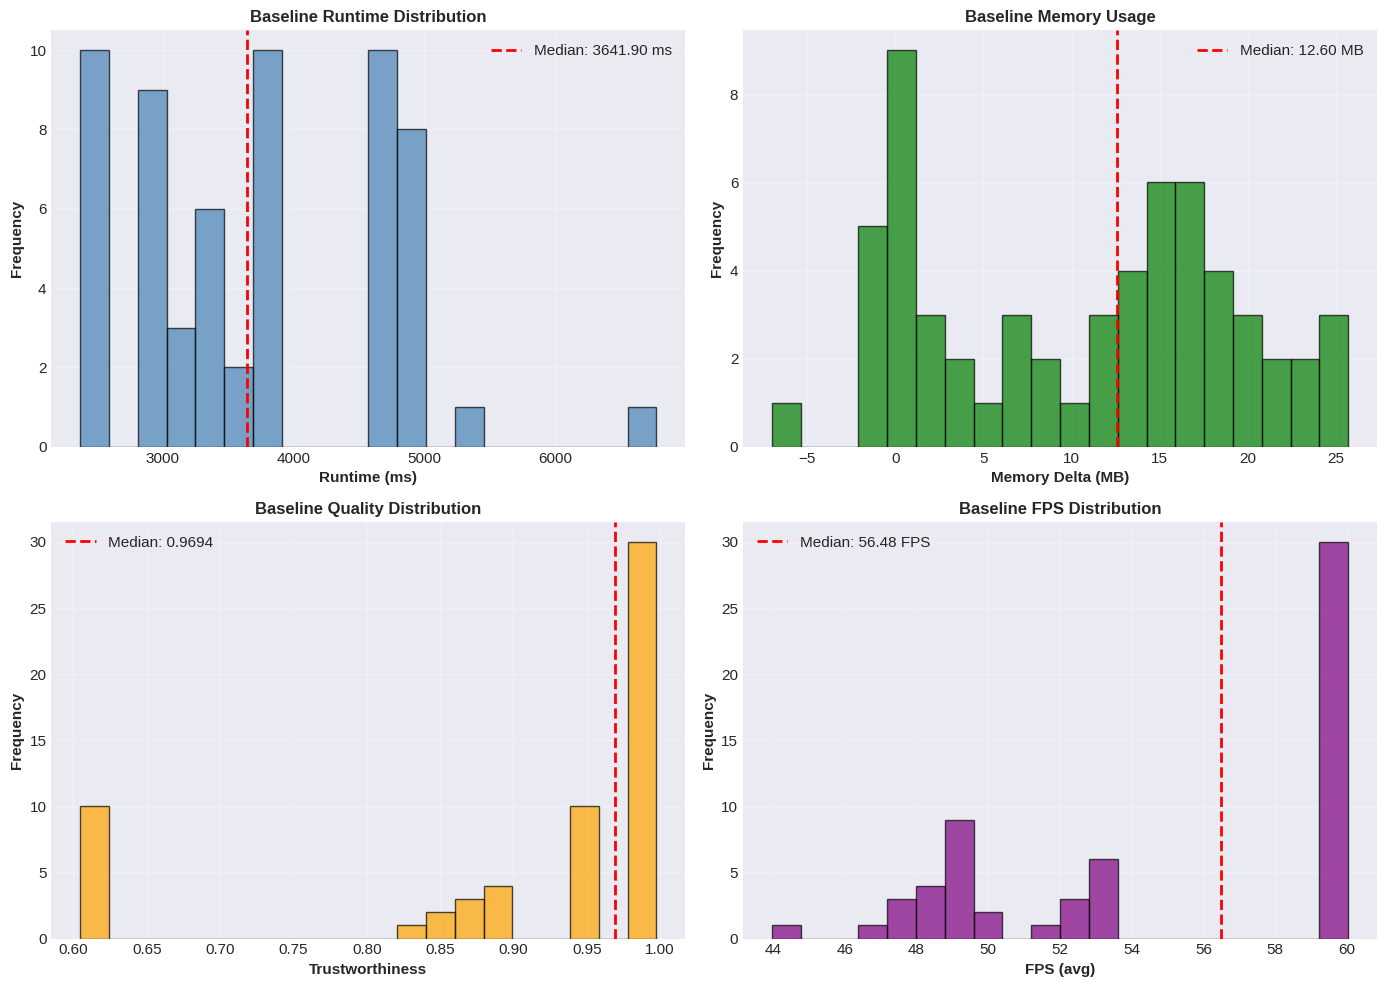

In [39]:
# Visualizations for Baseline
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Runtime distribution
axes[0, 0].hist(baseline_df['runtime_ms'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(baseline_df['runtime_ms'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {baseline_df["runtime_ms"].median():.2f} ms')
axes[0, 0].set_xlabel('Runtime (ms)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Baseline Runtime Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Memory usage
axes[0, 1].hist(baseline_df['memory_delta_mb'], bins=20, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].axvline(baseline_df['memory_delta_mb'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {baseline_df["memory_delta_mb"].median():.2f} MB')
axes[0, 1].set_xlabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Baseline Memory Usage', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Quality (Trustworthiness)
axes[1, 0].hist(baseline_df['trustworthiness'], bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].axvline(baseline_df['trustworthiness'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {baseline_df["trustworthiness"].median():.4f}')
axes[1, 0].set_xlabel('Trustworthiness', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Baseline Quality Distribution', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# FPS
axes[1, 1].hist(baseline_df['fps_avg'], bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].axvline(baseline_df['fps_avg'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {baseline_df["fps_avg"].median():.2f} FPS')
axes[1, 1].set_xlabel('FPS (avg)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Baseline FPS Distribution', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/baseline_metrics.png', bbox_inches='tight')
plt.show()

### 4.2 Distance Feature (WASM)

Performance metrics for WASM-accelerated distance calculations.

In [40]:
# Filter data for Distance feature
dist_df = df_analysis[df_analysis['feature_name'] == 'Distance'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: Distance")
print(f"{'='*80}")
print(f"Total measurements: {len(dist_df)}")
print(f"Datasets covered: {dist_df['dataset_name'].nunique()}")
if len(dist_df) > 0:
    print(f"Dataset names: {', '.join(sorted(dist_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = dist_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {dist_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        dist_median = dist_df['runtime_ms'].median()
        speedup = baseline_median / dist_median
        pct_change = ((dist_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = dist_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {dist_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = dist_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {dist_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = dist_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {dist_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = dist_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {dist_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = dist_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for Distance feature")

WASM FEATURE: Distance
Total measurements: 60
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   60
  Mean:    3686.94 ms
  Median:  3657.30 ms
  Std Dev: 866.48 ms
  Min:     2319.20 ms
  Max:     4933.90 ms
  25th %:  3003.67 ms
  75th %:  4706.22 ms

  vs Baseline: 1.00x speedup (+0.4%)

============================== Memory Usage (MB) ===============================
  Count:   60
  Mean:    10.01 MB
  Median:  11.90 MB
  Std Dev: 8.85 MB
  Min:     -6.87 MB
  Max:     26.00 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   60
  Mean:    0.9002
  Median:  0.9695
  Std Dev: 0.1397
  Min:     0.6049
  Max:     0.9974

============================== Visualization FPS ===============

runtime_ms                           memory_delta_mb         trustworthiness  \
                                          count   median     mean     std          median    mean          median   
dataset_name                                                                                                        
3D Dense Clusters (1K points)                10  4757.15  4756.34  75.894          12.758  13.533           0.997   
Iris Dataset (150 points, 4D)                10  2384.20  2384.58  31.996           1.963   1.873           0.988   
MNIST-like (1K points, 784D)                 10  4722.20  4715.47  50.631          14.981  13.773           0.607   
Medium Clustered (600 points)                10  3784.20  3806.41  64.353           4.749  10.519           0.951   
Small Random (80 points)                     10  3414.85  3426.55  72.008           0.881   4.465           0.861   
Swiss Roll (600 points, 3D manifold)         10  3002.05  3032.27  71.346          14.703  15.880           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  49.203  49.107            32.197   32.103  
Iris Dataset (150 points, 4D)         0.988  60.002  60.004             8.409    8.610  
MNIST-like (1K points, 784D)          0.609  59.960  59.964           116.632  116.050  
Medium Clustered (600 points)         0.951  53.121  52.688            21.520   22.397  
Small Random (80 points)              0.862  47.116  46.298            22.293   22.398  
Swiss Roll (600 points, 3D manifold)  0.994  59.999  59.998            18.582   18.788

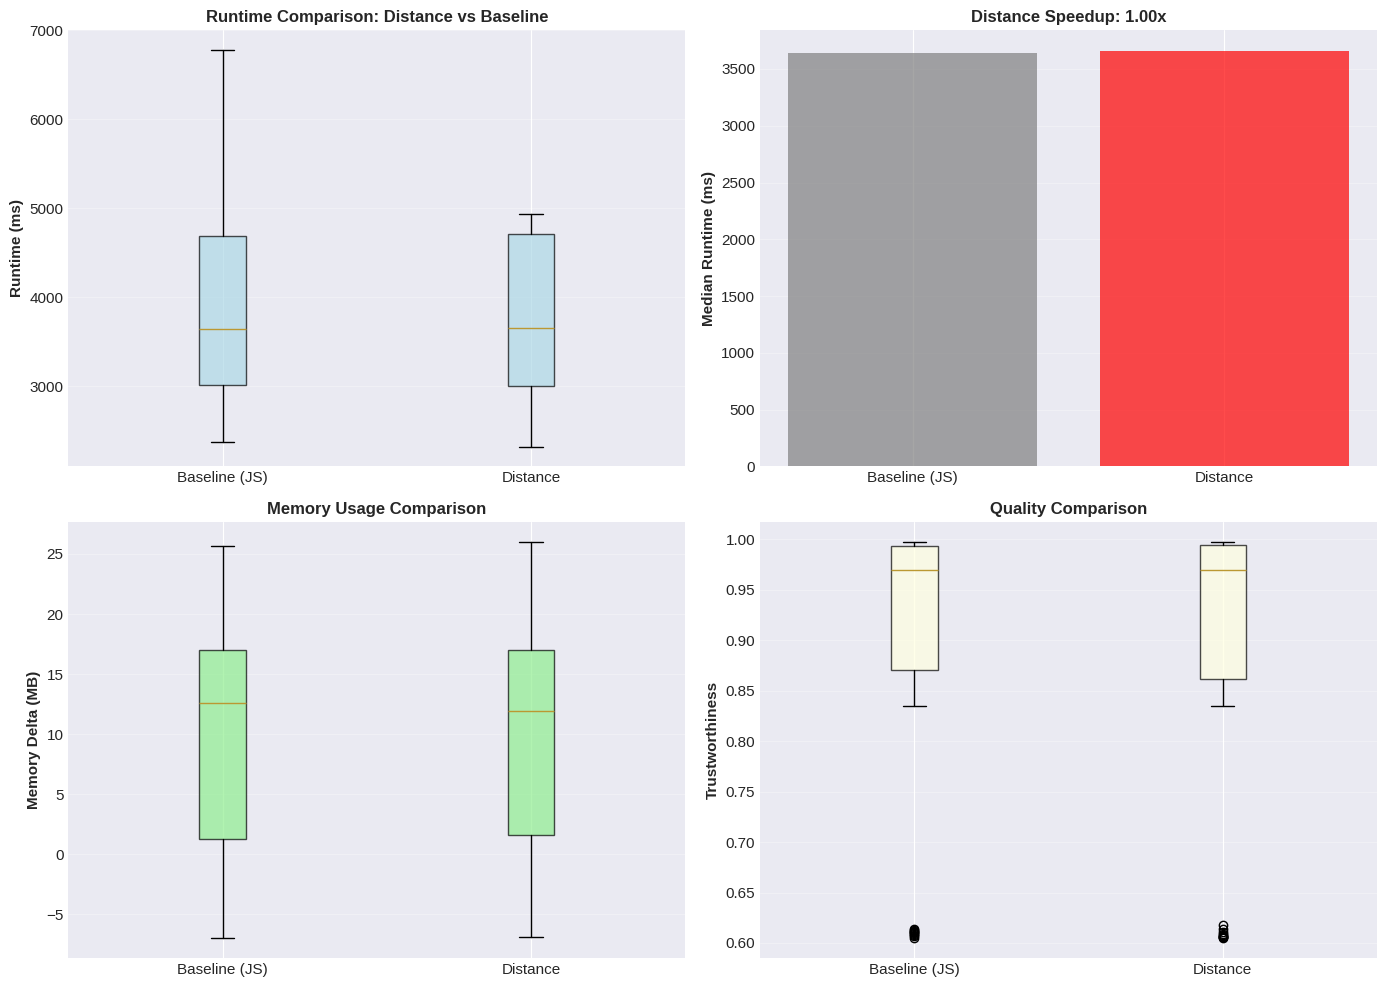

In [41]:
# Visualizations for Distance Feature
if len(dist_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Runtime comparison
    comparison_data = pd.DataFrame({
        'Baseline (JS)': baseline_df['runtime_ms'],
        'Distance': dist_df['runtime_ms']
    })
    axes[0, 0].boxplot([baseline_df['runtime_ms'], dist_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'Distance'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: Distance vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        dist_median = dist_df['runtime_ms'].median()
        speedup = baseline_median / dist_median
        
        axes[0, 1].bar(['Baseline (JS)', 'Distance'], 
                      [baseline_median, dist_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'Distance Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], dist_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'Distance'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], dist_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'Distance'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/distance_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")

### 4.3 Tree Feature (WASM)

Performance metrics for WASM-accelerated tree operations.

In [42]:
# Filter data for Tree feature
tree_df = df_analysis[df_analysis['feature_name'] == 'Tree'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: Tree")
print(f"{'='*80}")
print(f"Total measurements: {len(tree_df)}")
print(f"Datasets covered: {tree_df['dataset_name'].nunique()}")
if len(tree_df) > 0:
    print(f"Dataset names: {', '.join(sorted(tree_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = tree_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {tree_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        tree_median = tree_df['runtime_ms'].median()
        speedup = baseline_median / tree_median
        pct_change = ((tree_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = tree_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {tree_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = tree_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {tree_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = tree_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {tree_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = tree_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {tree_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = tree_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for Tree feature")

WASM FEATURE: Tree
Total measurements: 60
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   60
  Mean:    3649.20 ms
  Median:  3600.35 ms
  Std Dev: 890.80 ms
  Min:     2363.60 ms
  Max:     4968.20 ms
  25th %:  2997.47 ms
  75th %:  4647.90 ms

  vs Baseline: 1.01x speedup (-1.1%)

============================== Memory Usage (MB) ===============================
  Count:   60
  Mean:    17.10 MB
  Median:  13.43 MB
  Std Dev: 14.16 MB
  Min:     -2.71 MB
  Max:     49.68 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   60
  Mean:    0.8999
  Median:  0.9674
  Std Dev: 0.1401
  Min:     0.6025
  Max:     0.9975

============================== Visualization FPS ==================

runtime_ms                            memory_delta_mb         trustworthiness  \
                                          count   median     mean      std          median    mean          median   
dataset_name                                                                                                         
3D Dense Clusters (1K points)                10  4739.70  4795.19  120.233           7.636  10.698           0.997   
Iris Dataset (150 points, 4D)                10  2377.75  2380.86   12.878           3.143   5.500           0.988   
MNIST-like (1K points, 784D)                 10  4674.45  4689.74   82.842          45.845  44.335           0.607   
Medium Clustered (600 points)                10  3807.15  3815.77   55.690          18.524  14.318           0.950   
Small Random (80 points)                     10  3246.35  3175.50  168.044          11.537  10.898           0.864   
Swiss Roll (600 points, 3D manifold)         10  3005.00  3038.15   66.930          16.780  16.846           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  50.061  49.522            32.947   32.774  
Iris Dataset (150 points, 4D)         0.988  59.994  59.997             8.355    8.605  
MNIST-like (1K points, 784D)          0.607  59.981  59.964           109.782  111.283  
Medium Clustered (600 points)         0.950  53.097  52.792            22.867   22.628  
Small Random (80 points)              0.863  48.988  48.771            20.193   20.458  
Swiss Roll (600 points, 3D manifold)  0.994  59.997  59.995            18.845   18.836

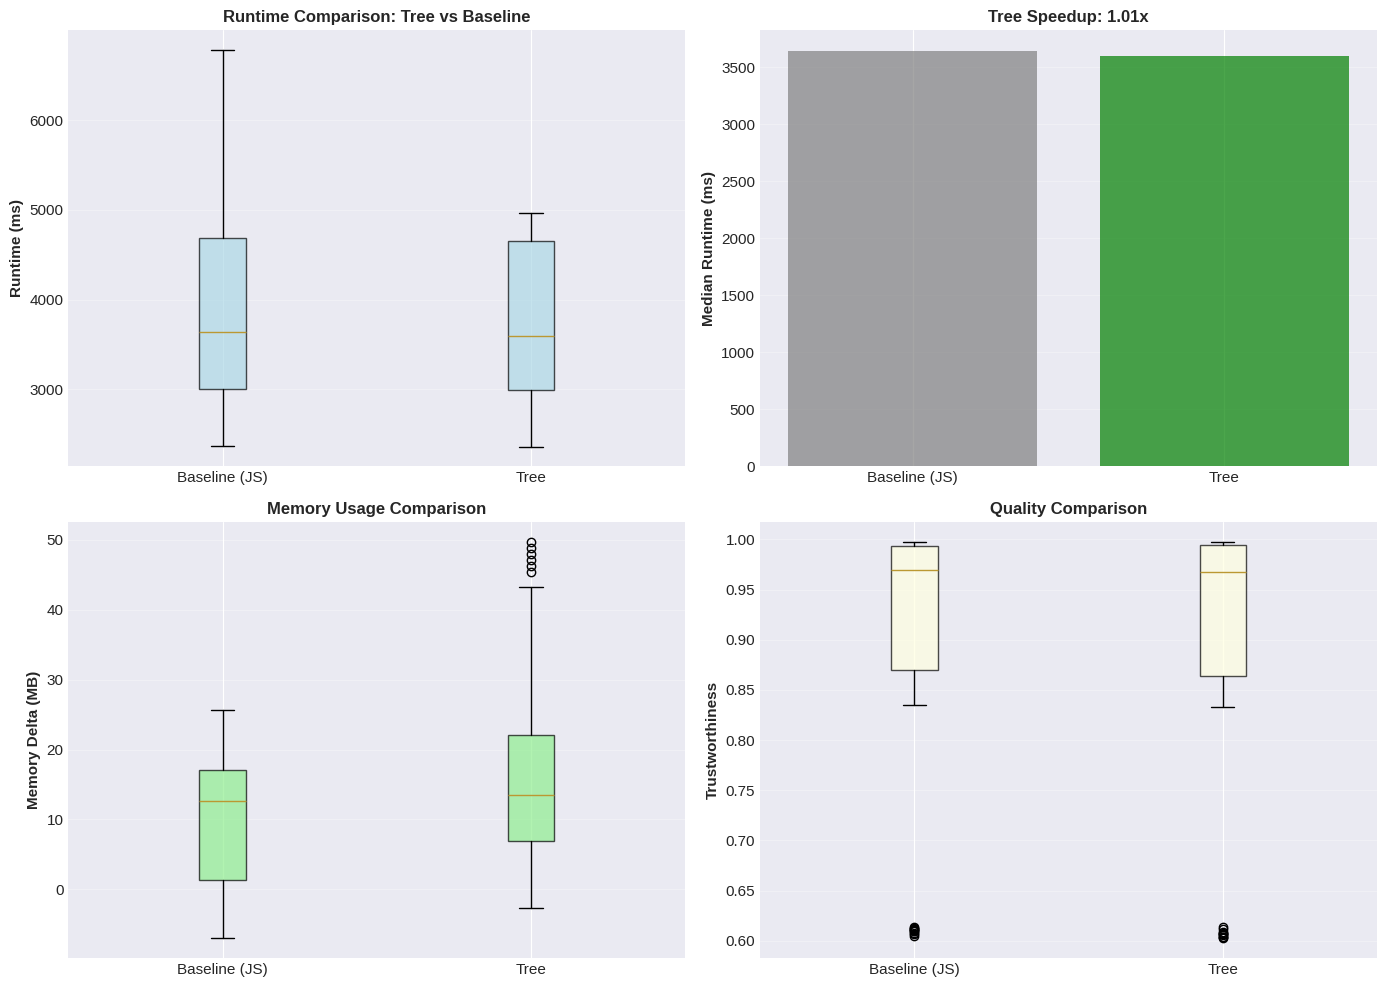

In [43]:
# Visualizations for Tree Feature
if len(tree_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Runtime comparison
    axes[0, 0].boxplot([baseline_df['runtime_ms'], tree_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'Tree'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: Tree vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        tree_median = tree_df['runtime_ms'].median()
        speedup = baseline_median / tree_median
        
        axes[0, 1].bar(['Baseline (JS)', 'Tree'], 
                      [baseline_median, tree_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'Tree Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], tree_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'Tree'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], tree_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'Tree'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/tree_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")

### 4.4 Matrix Feature (WASM)

Performance metrics for WASM-accelerated matrix operations.

In [44]:
# Filter data for NN Descent feature
nn_df = df_analysis[df_analysis['feature_name'] == 'NN Descent'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: NN Descent")
print(f"{'='*80}")
print(f"Total measurements: {len(nn_df)}")
print(f"Datasets covered: {nn_df['dataset_name'].nunique()}")
if len(nn_df) > 0:
    print(f"Dataset names: {', '.join(sorted(nn_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = nn_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {nn_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        nn_median = nn_df['runtime_ms'].median()
        speedup = baseline_median / nn_median
        pct_change = ((nn_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = nn_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {nn_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = nn_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {nn_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = nn_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {nn_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = nn_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {nn_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = nn_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for NN Descent feature")

WASM FEATURE: NN Descent
Total measurements: 60
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   60
  Mean:    3650.23 ms
  Median:  3548.10 ms
  Std Dev: 913.24 ms
  Min:     2365.60 ms
  Max:     5157.50 ms
  25th %:  2983.70 ms
  75th %:  4657.58 ms

  vs Baseline: 1.03x speedup (-2.6%)

============================== Memory Usage (MB) ===============================
  Count:   60
  Mean:    18.31 MB
  Median:  16.87 MB
  Std Dev: 13.29 MB
  Min:     -0.90 MB
  Max:     48.06 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   60
  Mean:    0.8995
  Median:  0.9702
  Std Dev: 0.1409
  Min:     0.5998
  Max:     0.9974

============================== Visualization FPS ============

runtime_ms                            memory_delta_mb         trustworthiness  \
                                          count   median     mean      std          median    mean          median   
dataset_name                                                                                                         
3D Dense Clusters (1K points)                10  4674.85  4696.91   78.044          16.872  16.766           0.997   
Iris Dataset (150 points, 4D)                10  2378.10  2378.27   10.324           0.444   3.740           0.989   
MNIST-like (1K points, 784D)                 10  4797.85  4843.72  148.059          38.624  38.634           0.605   
Medium Clustered (600 points)                10  3833.30  3858.70   53.187           9.817  14.241           0.951   
Small Random (80 points)                     10  2980.70  3040.49  133.967          11.748  11.822           0.864   
Swiss Roll (600 points, 3D manifold)         10  3066.95  3083.28   48.868          24.978  24.672           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  49.490  49.273            29.237   28.976  
Iris Dataset (150 points, 4D)         0.989  60.002  60.003             8.423    8.362  
MNIST-like (1K points, 784D)          0.605  59.989  60.009           116.782  117.168  
Medium Clustered (600 points)         0.951  52.567  52.085            22.570   22.911  
Small Random (80 points)              0.861  47.993  47.954            18.903   19.227  
Swiss Roll (600 points, 3D manifold)  0.994  59.993  59.980            19.668   19.925

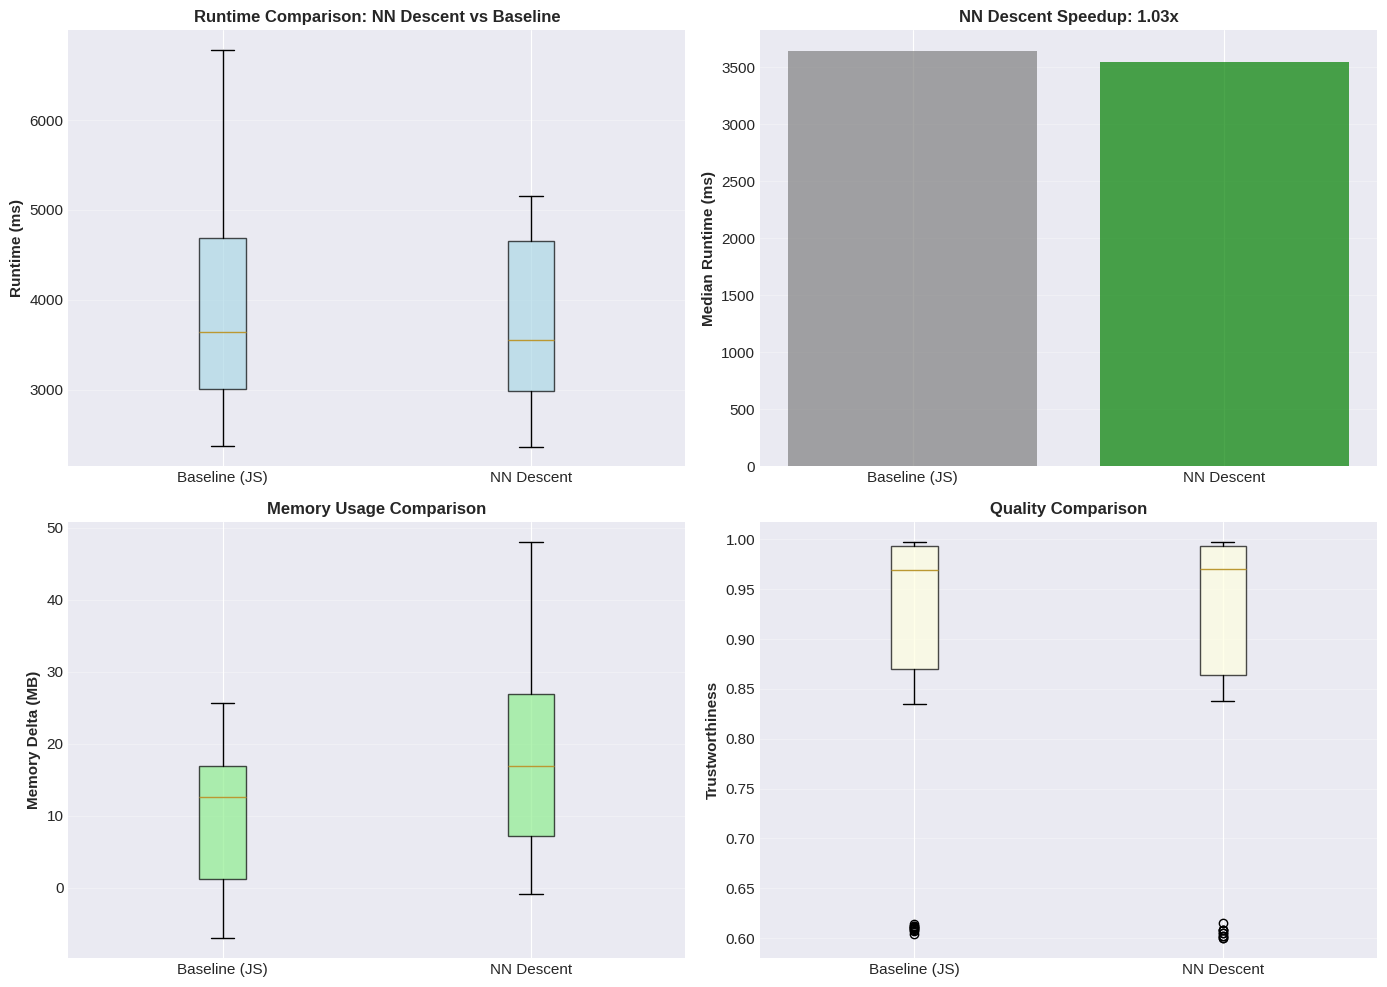

In [45]:
# Visualizations for NN Descent Feature
if len(nn_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Runtime comparison
    axes[0, 0].boxplot([baseline_df['runtime_ms'], nn_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'NN Descent'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: NN Descent vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        nn_median = nn_df['runtime_ms'].median()
        speedup = baseline_median / nn_median
        
        axes[0, 1].bar(['Baseline (JS)', 'NN Descent'], 
                      [baseline_median, nn_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'NN Descent Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], nn_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'NN Descent'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], nn_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'NN Descent'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/nn_descent_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")

### 4.6 Optimizer Feature (WASM)

Performance metrics for WASM-accelerated optimization.

In [46]:
# Filter data for All Features
all_df = df_analysis[df_analysis['feature_name'] == 'All Features'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: All Features Combined")
print(f"{'='*80}")
print(f"Total measurements: {len(all_df)}")
print(f"Datasets covered: {all_df['dataset_name'].nunique()}")
if len(all_df) > 0:
    print(f"Dataset names: {', '.join(sorted(all_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = all_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {all_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        all_median = all_df['runtime_ms'].median()
        speedup = baseline_median / all_median
        pct_change = ((all_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = all_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {all_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = all_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {all_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = all_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {all_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = all_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {all_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = all_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for All Features")

WASM FEATURE: All Features Combined
Total measurements: 60
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   60
  Mean:    2182.49 ms
  Median:  2023.60 ms
  Std Dev: 1281.16 ms
  Min:     647.30 ms
  Max:     4027.30 ms
  25th %:  776.33 ms
  75th %:  3553.30 ms

  vs Baseline: 1.80x speedup (-44.4%)

============================== Memory Usage (MB) ===============================
  Count:   60
  Mean:    10.77 MB
  Median:  11.92 MB
  Std Dev: 11.60 MB
  Min:     -10.44 MB
  Max:     35.37 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   60
  Mean:    0.8897
  Median:  0.9661
  Std Dev: 0.1538
  Min:     0.5609
  Max:     0.9974

============================== Visualization FPS 

runtime_ms                           memory_delta_mb         trustworthiness  \
                                          count   median     mean     std          median    mean          median   
dataset_name                                                                                                        
3D Dense Clusters (1K points)                10  3558.40  3563.74  32.527           4.896   4.527           0.997   
Iris Dataset (150 points, 4D)                10   673.10   671.46  17.313          13.198  12.769           0.986   
MNIST-like (1K points, 784D)                 10  4000.50  3977.81  51.870          28.190  28.515           0.571   
Medium Clustered (600 points)                10  2386.10  2401.69  90.585           3.017   6.586           0.949   
Small Random (80 points)                     10   775.55   774.43  28.527          -5.451  -3.993           0.848   
Swiss Roll (600 points, 3D manifold)         10  1697.95  1705.82  16.262          17.166  16.196           0.993   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  34.908  34.799            27.003   27.113  
Iris Dataset (150 points, 4D)         0.986   0.000   0.000            10.041    9.962  
MNIST-like (1K points, 784D)          0.570  37.569  37.011           106.545  104.943  
Medium Clustered (600 points)         0.949  48.197  47.662            19.813   19.612  
Small Random (80 points)              0.843   0.000   0.000            21.170   21.429  
Swiss Roll (600 points, 3D manifold)  0.994  47.455  47.628            15.764   15.709

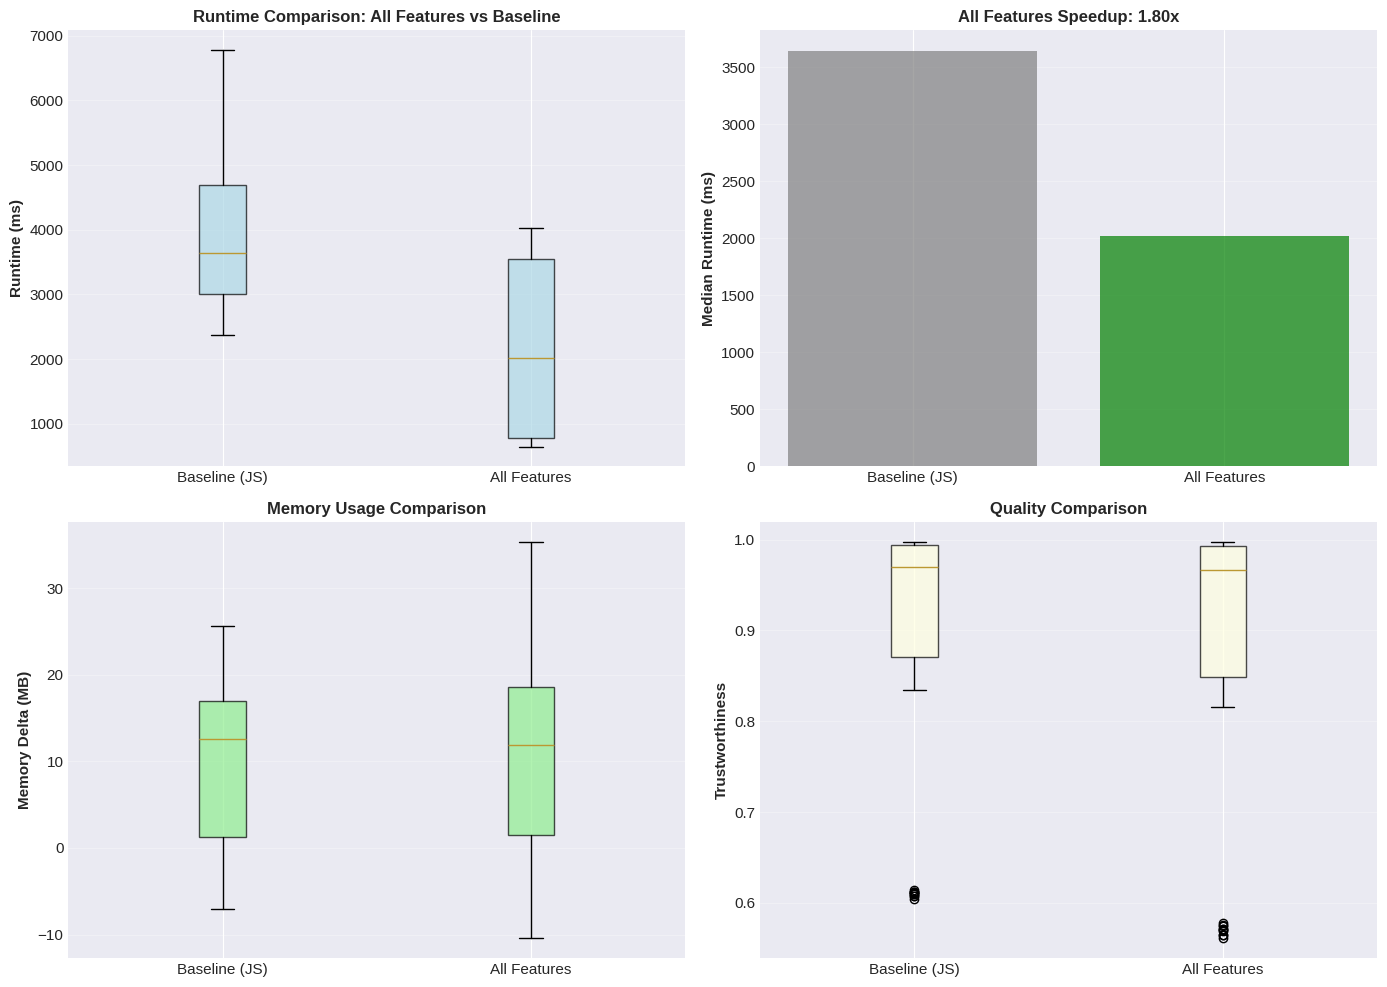

In [47]:
# Visualizations for All Features Combined
if len(all_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Runtime comparison
    axes[0, 0].boxplot([baseline_df['runtime_ms'], all_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'All Features'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: All Features vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        all_median = all_df['runtime_ms'].median()
        speedup = baseline_median / all_median
        
        axes[0, 1].bar(['Baseline (JS)', 'All Features'], 
                      [baseline_median, all_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'All Features Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], all_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'All Features'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], all_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'All Features'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/all_features_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")

In [48]:
# Filter data for Optimizer feature
opt_df = df_analysis[df_analysis['feature_name'] == 'Optimizer'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: Optimizer")
print(f"{'='*80}")
print(f"Total measurements: {len(opt_df)}")
print(f"Datasets covered: {opt_df['dataset_name'].nunique()}")
if len(opt_df) > 0:
    print(f"Dataset names: {', '.join(sorted(opt_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = opt_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {opt_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        opt_median = opt_df['runtime_ms'].median()
        speedup = baseline_median / opt_median
        pct_change = ((opt_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = opt_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {opt_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = opt_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {opt_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = opt_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {opt_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = opt_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {opt_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = opt_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for Optimizer feature")

WASM FEATURE: Optimizer
Total measurements: 60
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   60
  Mean:    2246.63 ms
  Median:  2174.75 ms
  Std Dev: 1354.12 ms
  Min:     616.60 ms
  Max:     4558.50 ms
  25th %:  721.10 ms
  75th %:  3630.05 ms

  vs Baseline: 1.67x speedup (-40.3%)

============================== Memory Usage (MB) ===============================
  Count:   60
  Mean:    7.29 MB
  Median:  2.92 MB
  Std Dev: 8.07 MB
  Min:     -8.34 MB
  Max:     24.97 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   60
  Mean:    0.8879
  Median:  0.9667
  Std Dev: 0.1565
  Min:     0.5515
  Max:     0.9972

============================== Visualization FPS ================

runtime_ms                            memory_delta_mb         trustworthiness  \
                                          count   median     mean      std          median    mean          median   
dataset_name                                                                                                         
3D Dense Clusters (1K points)                10  3645.10  3734.99  315.210           7.874   8.746           0.997   
Iris Dataset (150 points, 4D)                10   624.30   631.03   22.164           0.065   0.085           0.986   
MNIST-like (1K points, 784D)                 10  4029.45  4057.55  109.996           0.642   3.895           0.564   
Medium Clustered (600 points)                10  2531.30  2548.60   64.869          14.110  13.714           0.948   
Small Random (80 points)                     10   720.20   732.61   40.122           1.356   1.414           0.841   
Swiss Roll (600 points, 3D manifold)         10  1767.50  1774.98   44.276          15.234  15.885           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  35.082  34.944            30.997   31.739  
Iris Dataset (150 points, 4D)         0.985   0.000   0.000             7.886    6.554  
MNIST-like (1K points, 784D)          0.563  38.601  37.989           113.891  116.681  
Medium Clustered (600 points)         0.948  46.673  45.950            24.290   24.331  
Small Random (80 points)              0.840   0.000   0.000            19.070   19.401  
Swiss Roll (600 points, 3D manifold)  0.994  45.147  45.131            19.245   19.508

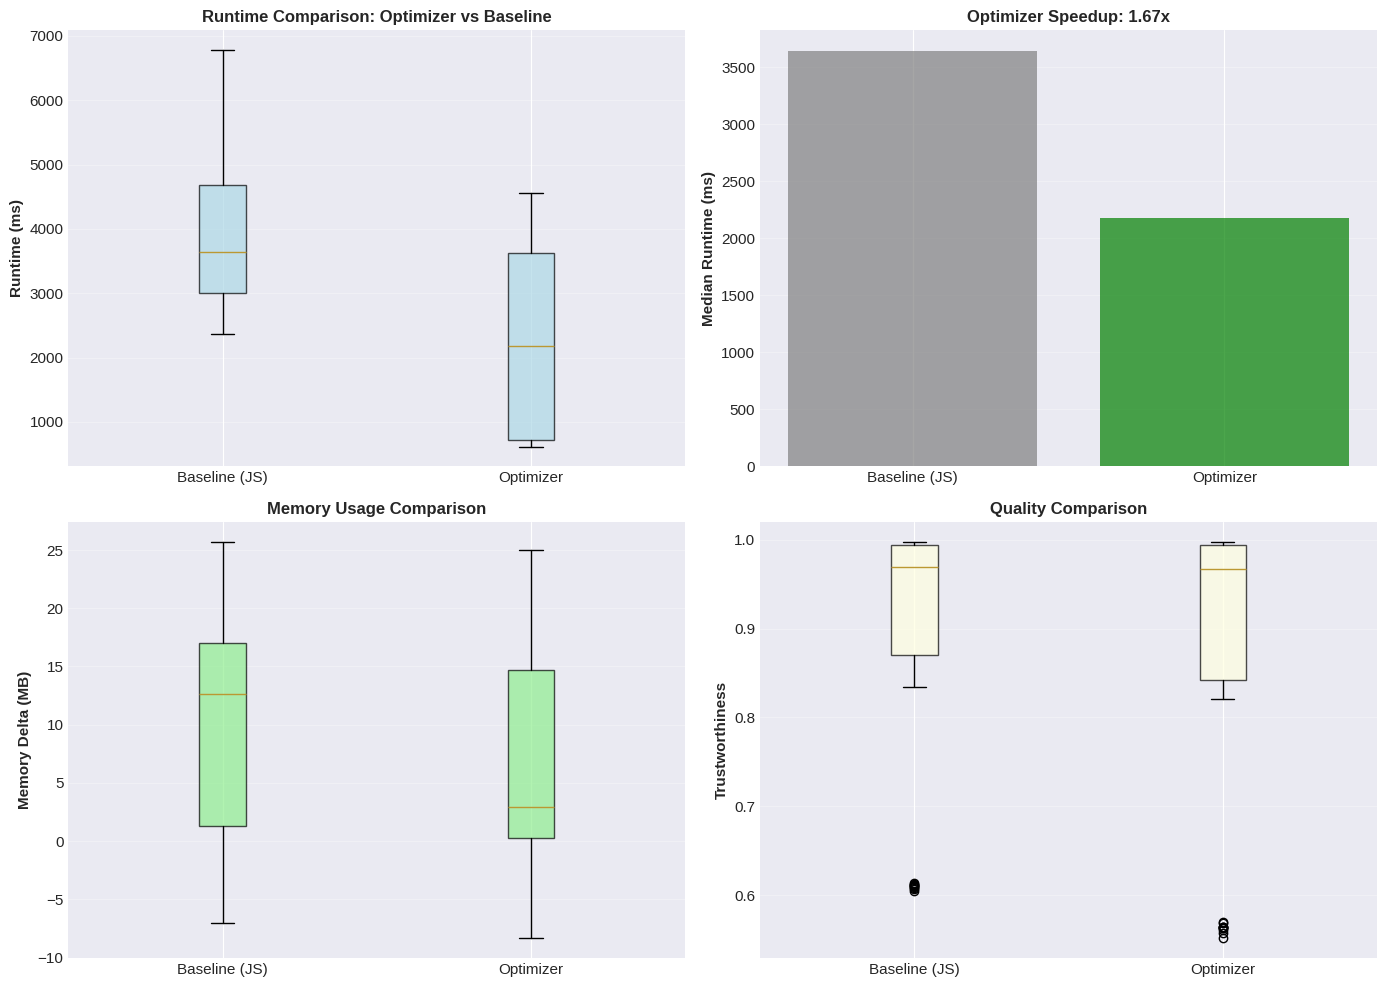

In [49]:
# Visualizations for Optimizer Feature
if len(opt_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Runtime comparison
    axes[0, 0].boxplot([baseline_df['runtime_ms'], opt_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'Optimizer'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: Optimizer vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        opt_median = opt_df['runtime_ms'].median()
        speedup = baseline_median / opt_median
        
        axes[0, 1].bar(['Baseline (JS)', 'Optimizer'], 
                      [baseline_median, opt_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'Optimizer Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], opt_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'Optimizer'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], opt_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'Optimizer'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/optimizer_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")

### 4.7 All Features Combined (WASM)

Performance metrics for all WASM features enabled simultaneously.

In [50]:
# Filter data for Matrix feature
matrix_df = df_analysis[df_analysis['feature_name'] == 'Matrix'].copy()

print(f"{'='*80}")
print(f"WASM FEATURE: Matrix")
print(f"{'='*80}")
print(f"Total measurements: {len(matrix_df)}")
print(f"Datasets covered: {matrix_df['dataset_name'].nunique()}")
if len(matrix_df) > 0:
    print(f"Dataset names: {', '.join(sorted(matrix_df['dataset_name'].unique()))}")

    # Runtime Metrics
    print(f"\n{' Runtime (ms) ':=^80}")
    runtime_stats = matrix_df['runtime_ms'].describe()
    print(f"  Count:   {runtime_stats['count']:.0f}")
    print(f"  Mean:    {runtime_stats['mean']:.2f} ms")
    print(f"  Median:  {matrix_df['runtime_ms'].median():.2f} ms")
    print(f"  Std Dev: {runtime_stats['std']:.2f} ms")
    print(f"  Min:     {runtime_stats['min']:.2f} ms")
    print(f"  Max:     {runtime_stats['max']:.2f} ms")
    print(f"  25th %:  {runtime_stats['25%']:.2f} ms")
    print(f"  75th %:  {runtime_stats['75%']:.2f} ms")
    
    # Comparison to Baseline
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        matrix_median = matrix_df['runtime_ms'].median()
        speedup = baseline_median / matrix_median
        pct_change = ((matrix_median - baseline_median) / baseline_median) * 100
        print(f"\n  vs Baseline: {speedup:.2f}x speedup ({pct_change:+.1f}%)")

    # Memory Usage
    print(f"\n{' Memory Usage (MB) ':=^80}")
    memory_stats = matrix_df['memory_delta_mb'].describe()
    print(f"  Count:   {memory_stats['count']:.0f}")
    print(f"  Mean:    {memory_stats['mean']:.2f} MB")
    print(f"  Median:  {matrix_df['memory_delta_mb'].median():.2f} MB")
    print(f"  Std Dev: {memory_stats['std']:.2f} MB")
    print(f"  Min:     {memory_stats['min']:.2f} MB")
    print(f"  Max:     {memory_stats['max']:.2f} MB")

    # Embedding Quality
    print(f"\n{' Embedding Quality (Trustworthiness) ':=^80}")
    quality_stats = matrix_df['trustworthiness'].describe()
    print(f"  Count:   {quality_stats['count']:.0f}")
    print(f"  Mean:    {quality_stats['mean']:.4f}")
    print(f"  Median:  {matrix_df['trustworthiness'].median():.4f}")
    print(f"  Std Dev: {quality_stats['std']:.4f}")
    print(f"  Min:     {quality_stats['min']:.4f}")
    print(f"  Max:     {quality_stats['max']:.4f}")

    # Visualization FPS
    print(f"\n{' Visualization FPS ':=^80}")
    fps_stats = matrix_df['fps_avg'].describe()
    print(f"  Count:   {fps_stats['count']:.0f}")
    print(f"  Mean:    {fps_stats['mean']:.2f} FPS")
    print(f"  Median:  {matrix_df['fps_avg'].median():.2f} FPS")
    print(f"  Std Dev: {fps_stats['std']:.2f} FPS")
    print(f"  Min:     {fps_stats['min']:.2f} FPS")
    print(f"  Max:     {fps_stats['max']:.2f} FPS")

    # Responsiveness
    print(f"\n{' Responsiveness (ms) ':=^80}")
    resp_stats = matrix_df['responsiveness_ms'].describe()
    print(f"  Count:   {resp_stats['count']:.0f}")
    print(f"  Mean:    {resp_stats['mean']:.2f} ms")
    print(f"  Median:  {matrix_df['responsiveness_ms'].median():.2f} ms")
    print(f"  Std Dev: {resp_stats['std']:.2f} ms")
    print(f"  Min:     {resp_stats['min']:.2f} ms")
    print(f"  Max:     {resp_stats['max']:.2f} ms")

    # Per-Dataset Summary
    print(f"\n{' Per-Dataset Summary ':=^80}")
    dataset_summary = matrix_df.groupby('dataset_name').agg({
        'runtime_ms': ['count', 'median', 'mean', 'std'],
        'memory_delta_mb': ['median', 'mean'],
        'trustworthiness': ['median', 'mean'],
        'fps_avg': ['median', 'mean'],
        'responsiveness_ms': ['median', 'mean']
    }).round(3)
    display(dataset_summary)
else:
    print("\n⚠️  No data available for Matrix feature")

WASM FEATURE: Matrix
Total measurements: 60
Datasets covered: 6
Dataset names: 3D Dense Clusters (1K points), Iris Dataset (150 points, 4D), MNIST-like (1K points, 784D), Medium Clustered (600 points), Small Random (80 points), Swiss Roll (600 points, 3D manifold)

================================= Runtime (ms) =================================
  Count:   60
  Mean:    3650.65 ms
  Median:  3546.05 ms
  Std Dev: 906.89 ms
  Min:     2353.40 ms
  Max:     5072.70 ms
  25th %:  2993.88 ms
  75th %:  4653.97 ms

  vs Baseline: 1.03x speedup (-2.6%)

============================== Memory Usage (MB) ===============================
  Count:   60
  Mean:    15.54 MB
  Median:  15.27 MB
  Std Dev: 9.63 MB
  Min:     -1.28 MB
  Max:     38.43 MB

===================== Embedding Quality (Trustworthiness) ======================
  Count:   60
  Mean:    0.8999
  Median:  0.9691
  Std Dev: 0.1394
  Min:     0.6037
  Max:     0.9975

============================== Visualization FPS =================

runtime_ms                            memory_delta_mb         trustworthiness  \
                                          count   median     mean      std          median    mean          median   
dataset_name                                                                                                         
3D Dense Clusters (1K points)                10  4675.40  4705.06   89.959          15.525  14.312           0.997   
Iris Dataset (150 points, 4D)                10  2388.45  2387.34   28.412           9.179   8.579           0.988   
MNIST-like (1K points, 784D)                 10  4733.30  4807.64  166.750          29.093  27.429           0.609   
Medium Clustered (600 points)                10  3825.10  3863.98  167.551          17.656  18.990           0.951   
Small Random (80 points)                     10  3011.95  3118.09  153.789           4.652   6.983           0.863   
Swiss Roll (600 points, 3D manifold)         10  3019.15  3021.78   46.466          19.327  16.924           0.994   

                                            fps_avg         responsiveness_ms           
                                       mean  median    mean            median     mean  
dataset_name                                                                            
3D Dense Clusters (1K points)         0.997  48.983  49.236            29.097   29.600  
Iris Dataset (150 points, 4D)         0.988  60.000  59.999             9.164    8.993  
MNIST-like (1K points, 784D)          0.609  59.997  59.960           109.791  110.781  
Medium Clustered (600 points)         0.951  52.129  51.873            21.420   22.269  
Small Random (80 points)              0.860  47.986  48.116            19.123   19.269  
Swiss Roll (600 points, 3D manifold)  0.994  60.019  60.015            17.150   17.050

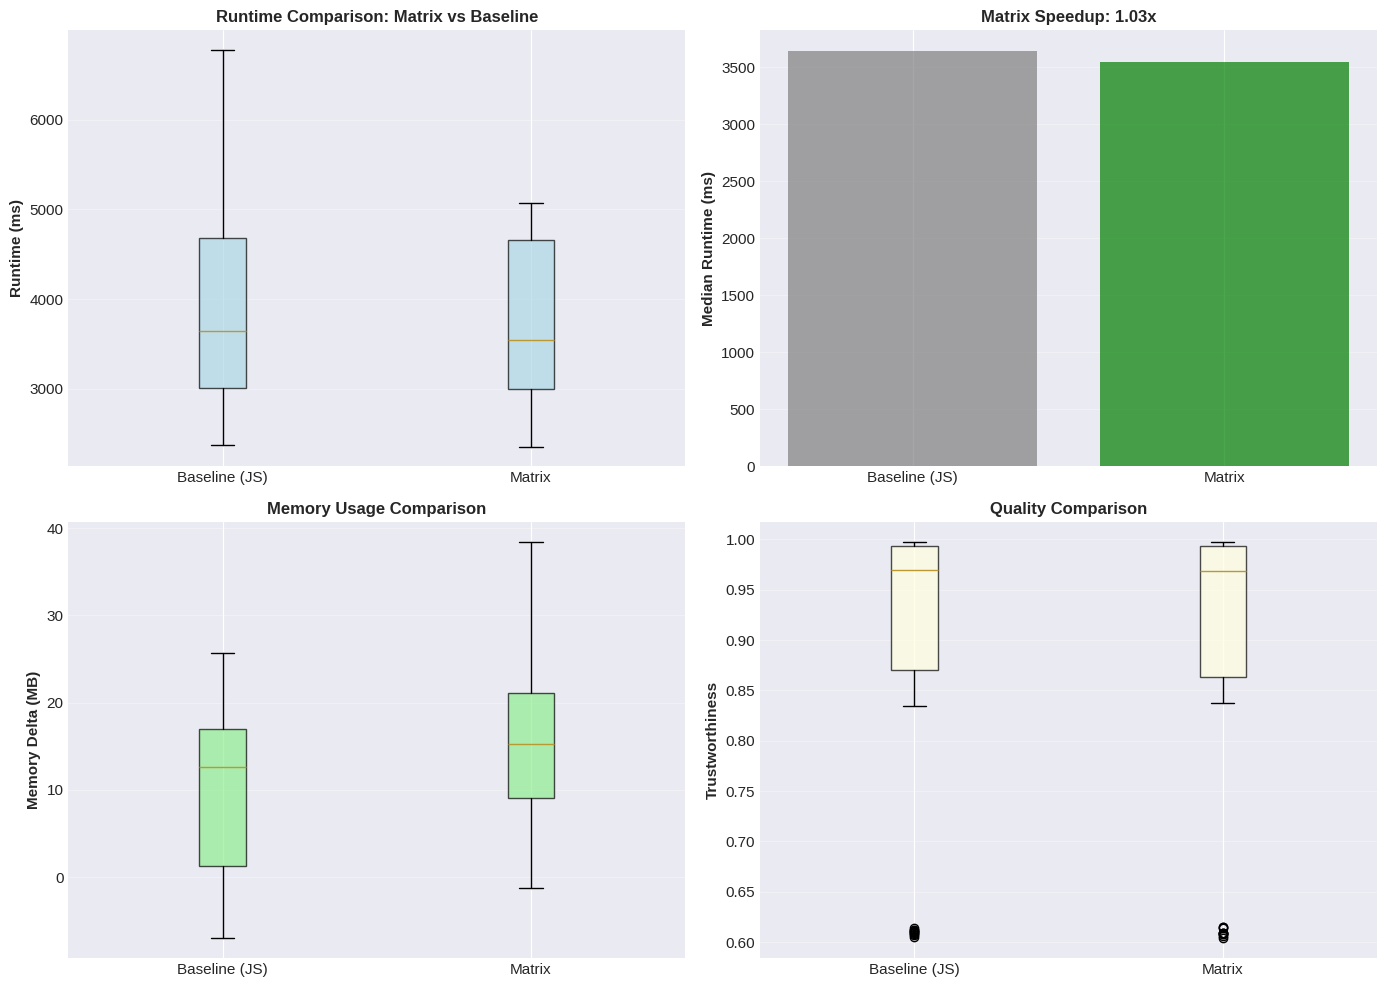

In [51]:
# Visualizations for Matrix Feature
if len(matrix_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Runtime comparison
    axes[0, 0].boxplot([baseline_df['runtime_ms'], matrix_df['runtime_ms']], 
                       labels=['Baseline (JS)', 'Matrix'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11, fontweight='bold')
    axes[0, 0].set_title('Runtime Comparison: Matrix vs Baseline', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Speedup visualization
    if len(baseline_df) > 0:
        baseline_median = baseline_df['runtime_ms'].median()
        matrix_median = matrix_df['runtime_ms'].median()
        speedup = baseline_median / matrix_median
        
        axes[0, 1].bar(['Baseline (JS)', 'Matrix'], 
                      [baseline_median, matrix_median],
                      color=['gray', 'green' if speedup > 1 else 'red'],
                      alpha=0.7)
        axes[0, 1].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
        axes[0, 1].set_title(f'Matrix Speedup: {speedup:.2f}x', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Memory comparison
    axes[1, 0].boxplot([baseline_df['memory_delta_mb'], matrix_df['memory_delta_mb']], 
                       labels=['Baseline (JS)', 'Matrix'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[1, 0].set_ylabel('Memory Delta (MB)', fontsize=11, fontweight='bold')
    axes[1, 0].set_title('Memory Usage Comparison', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Quality comparison
    axes[1, 1].boxplot([baseline_df['trustworthiness'], matrix_df['trustworthiness']], 
                       labels=['Baseline (JS)', 'Matrix'],
                       patch_artist=True,
                       boxprops=dict(facecolor='lightyellow', alpha=0.7))
    axes[1, 1].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Quality Comparison', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/matrix_comparison.png', bbox_inches='tight')
    plt.show()
else:
    print("No visualizations available (insufficient data)")

### 4.5 NN Descent Feature (WASM)

Performance metrics for WASM-accelerated nearest neighbor descent.

In [52]:
# Data Quality Checks
print("Data Quality Checks:")
print(f"Negative runtime values: {(df_analysis['runtime_ms'] < 0).sum()}")
print(f"Trustworthiness out of range [0,1]: {(~df_analysis['trustworthiness'].between(0, 1)).sum()}")
print(f"Negative FPS: {(df_analysis['fps_avg'] < 0).sum()}")
print(f"\nRuntime statistics by feature:")
df_analysis.groupby('feature_name')['runtime_ms'].describe()

Data Quality Checks:
Negative runtime values: 0
Trustworthiness out of range [0,1]: 0
Negative FPS: 0

Runtime statistics by feature:


,count,mean,std,min,25%,50%,75%,max
feature_name,,,,,,,,
All Features,60.0,2182.492,1281.163,647.3,776.325,2023.60,3553.300,4027.3
Baseline (JS),60.0,3717.213,978.373,2368.3,3006.750,3641.90,4685.550,6777.8
Distance,60.0,3686.937,866.484,2319.2,3003.675,3657.30,4706.225,4933.9
Matrix,60.0,3650.648,906.894,2353.4,2993.875,3546.05,4653.975,5072.7
NN Descent,60.0,3650.228,913.242,2365.6,2983.700,3548.10,4657.575,5157.5
Optimizer,60.0,2246.627,1354.119,616.6,721.100,2174.75,3630.050,4558.5
Tree,60.0,3649.202,890.800,2363.6,2997.475,3600.35,4647.900,4968.2


## 5. Performance Distribution Analysis

Analyze the performance distribution across different features for the selected machine.

In [53]:
# Summary statistics by feature
feature_summary = df_analysis.groupby('feature_name').agg({
    'runtime_ms': ['count', 'mean', 'std', 'median', 'min', 'max'],
    'memory_delta_mb': ['mean', 'median'],
    'trustworthiness': ['mean', 'median'],
    'fps_avg': ['mean', 'median'],
    'responsiveness_ms': ['mean', 'median']
}).round(2)

print("Performance Summary:")
feature_summary

Performance Summary:


runtime_ms                                            memory_delta_mb        trustworthiness         \
                   count     mean      std   median     min     max            mean median            mean median   
feature_name                                                                                                        
All Features          60  2182.49  1281.16  2023.60   647.3  4027.3           10.77  11.92            0.89   0.97   
Baseline (JS)         60  3717.21   978.37  3641.90  2368.3  6777.8           10.57  12.60            0.90   0.97   
Distance              60  3686.94   866.48  3657.30  2319.2  4933.9           10.01  11.90            0.90   0.97   
Matrix                60  3650.65   906.89  3546.05  2353.4  5072.7           15.54  15.27            0.90   0.97   
NN Descent            60  3650.23   913.24  3548.10  2365.6  5157.5           18.31  16.87            0.90   0.97   
Optimizer             60  2246.63  1354.12  2174.75   616.6  4558.5            7.29   2.92            0.89   0.97   
Tree                  60  3649.20   890.80  3600.35  2363.6  4968.2           17.10  13.43            0.90   0.97   

              fps_avg        responsiveness_ms         
                 mean median              mean median  
feature_name                                           
All Features    27.85  35.31             33.13  20.31  
Baseline (JS)   54.91  56.48             36.76  21.34  
Distance        54.68  56.54             36.72  21.81  
Matrix          54.87  56.44             34.66  20.17  
NN Descent      54.88  56.53             36.09  21.67  
Optimizer       27.34  36.35             36.37  22.26  
Tree            55.17  56.50             35.76  21.80

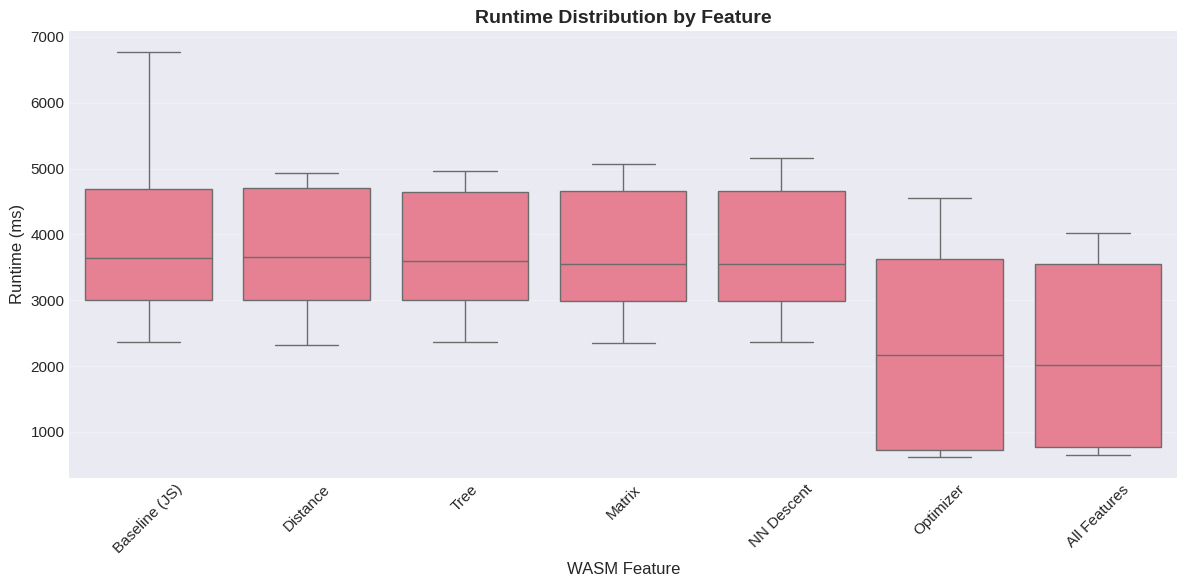

In [54]:
# Visualize runtime distribution by feature
fig, ax = plt.subplots(figsize=(12, 6))

# Order features logically
feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

sns.boxplot(data=df_analysis, x='feature_name', y='runtime_ms', 
            order=feature_order, ax=ax, showfliers=False)
ax.set_title('Runtime Distribution by Feature', fontsize=14, fontweight='bold')
ax.set_xlabel('WASM Feature', fontsize=12)
ax.set_ylabel('Runtime (ms)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/runtime_distribution.png', bbox_inches='tight')
plt.show()

## 6. Comparative Analysis: Speedup Calculations

Compare all features relative to the baseline.

In [55]:
def calculate_speedup(df, baseline_feature='Baseline (JS)', machine=None):
    """
    Calculate speedup relative to baseline for each machine/dataset combination.
    """
    results = []
    
    # Filter by machine if specified
    data = df[df['machine_type'] == machine] if machine else df
    
    # Group by dataset and machine
    for (dataset, mach), group in data.groupby(['dataset_name', 'machine_type']):
        baseline = group[group['feature_name'] == baseline_feature]['runtime_ms']
        
        if len(baseline) == 0:
            continue
            
        baseline_median = baseline.median()
        
        for feature in group['feature_name'].unique():
            if feature == baseline_feature:
                continue
                
            feature_data = group[group['feature_name'] == feature]
            if len(feature_data) == 0:
                continue
            
            feature_median = feature_data['runtime_ms'].median()
            speedup = baseline_median / feature_median
            
            results.append({
                'dataset': dataset,
                'machine': mach,
                'feature': feature,
                'baseline_median_ms': baseline_median,
                'feature_median_ms': feature_median,
                'speedup': speedup,
                'improvement_pct': (speedup - 1) * 100
            })
    
    return pd.DataFrame(results)

# Calculate speedups
speedup_df = calculate_speedup(df_analysis)

print("Speedup Summary:")
speedup_summary = speedup_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'std', 'min', 'max'],
    'improvement_pct': ['mean', 'median']
}).round(3)
speedup_summary

Speedup Summary:


speedup                             improvement_pct        
                mean median    std    min    max            mean  median
feature                                                                 
All Features   2.279  1.677  1.284  1.183  4.244         127.862  67.744
Distance       0.996  1.000  0.017  0.964  1.012          -0.382   0.024
Matrix         1.017  0.998  0.040  0.989  1.093           1.720  -0.170
NN Descent     1.015  0.994  0.047  0.980  1.104           1.468  -0.591
Optimizer      2.346  1.597  1.461  1.174  4.570         134.552  59.716
Tree           1.006  1.007  0.009  0.994  1.016           0.613   0.684

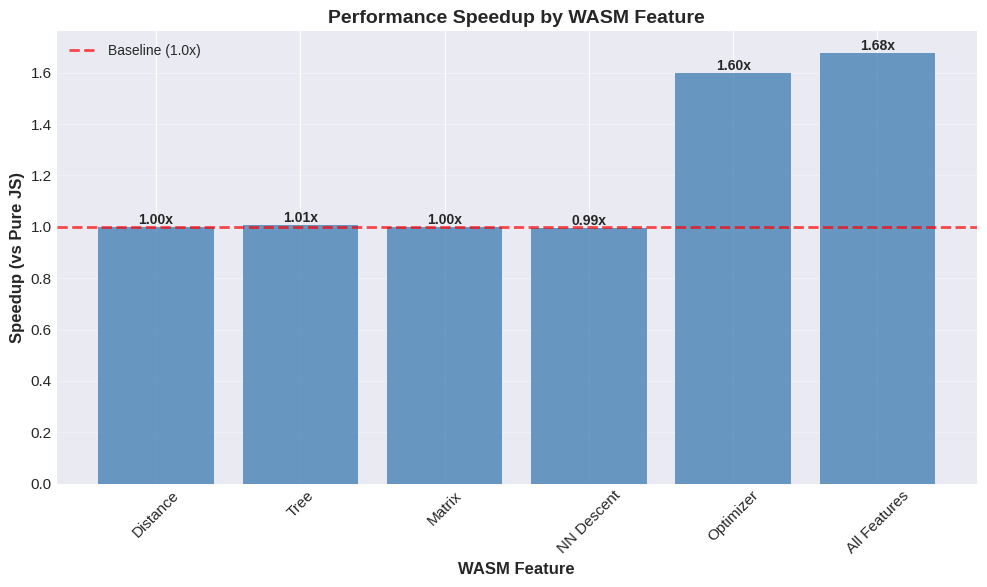

In [16]:
# Detailed speedup by feature
feature_order = ['Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in speedup_df['feature'].unique()]

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate median speedup for each feature
feature_speedups = speedup_df.groupby('feature')['speedup'].median()
values = [feature_speedups.get(f, 0) for f in feature_order]

bars = ax.bar(feature_order, values, alpha=0.8, color='steelblue')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}x',
               ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Baseline (1.0x)', alpha=0.7)
ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
ax.set_ylabel('Speedup (vs Pure JS)', fontsize=12, fontweight='bold')
ax.set_title('Performance Speedup by WASM Feature', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_comparison.png', bbox_inches='tight')
plt.show()

## 7. Dataset Size Analysis

Analyze how performance scales with dataset size and whether WASM features show different benefits for small vs large datasets.

In [56]:
# Extract dataset size information from the existing 'dataset_size' column
# This column is already in the CSV from the benchmark runs
df_analysis['dataset_size'] = pd.to_numeric(df_analysis['dataset_size'], errors='coerce')

# Benchmark dataset sizes:
# Small scope: Iris (150), Small Random (80)
# Mid scope: Swiss Roll (600), Medium Clustered (600)
# Large scope: MNIST-like (1000), 3D Dense Clusters (1000)

# Create size categories based on actual benchmark dataset sizes
df_analysis['size_category'] = pd.cut(
    df_analysis['dataset_size'], 
    bins=[0, 200, 800, float('inf')],
    labels=['Small (≤200)', 'Medium (200-800)', 'Large (>800)']
)

print("Dataset Size Distribution:")
print(df_analysis.groupby('dataset_name')['dataset_size'].first().sort_values())
print(f"\nSize category distribution:")
print(df_analysis['size_category'].value_counts().sort_index())

Dataset Size Distribution:
dataset_name
Small Random (80 points)                  80
Iris Dataset (150 points, 4D)            150
Swiss Roll (600 points, 3D manifold)     600
Medium Clustered (600 points)            600
MNIST-like (1K points, 784D)            1000
3D Dense Clusters (1K points)           1000
Name: dataset_size, dtype: int64

Size category distribution:
size_category
Small (≤200)        140
Medium (200-800)    140
Large (>800)        140
Name: count, dtype: int64


In [57]:
# Analyze runtime by dataset size and feature
size_performance = df_analysis.groupby(['dataset_name', 'dataset_size', 'feature_name']).agg({
    'runtime_ms': ['mean', 'median', 'std', 'count']
}).round(2)

print("Runtime by Dataset Size and Feature:")
print("\nSummary statistics:")
size_summary = df_analysis.groupby(['dataset_size', 'feature_name']).agg({
    'runtime_ms': ['mean', 'median', 'std']
}).round(2)
size_summary

Runtime by Dataset Size and Feature:

Summary statistics:


runtime_ms                 
                                 mean   median     std
dataset_size feature_name                             
80           All Features      774.43   775.55   28.53
             Baseline (JS)    3317.47  3291.05  141.46
             Distance         3426.55  3414.85   72.01
             Matrix           3118.09  3011.95  153.79
             NN Descent       3040.49  2980.70  133.97
             Optimizer         732.61   720.20   40.12
             Tree             3175.50  3246.35  168.04
150          All Features      671.46   673.10   17.31
             Baseline (JS)    2392.29  2381.05   24.83
             Distance         2384.58  2384.20   32.00
             Matrix           2387.34  2388.45   28.41
             NN Descent       2378.27  2378.10   10.32
             Optimizer         631.03   624.30   22.16
             Tree             2380.86  2377.75   12.88
600          All Features     2053.76  2023.60  362.55
             Baseline (JS)    3399.49  3417.40  400.17
             Distance         3419.34  3472.20  402.59
             Matrix           3442.88  3443.95  448.31
             NN Descent       3470.99  3495.85  400.88
             Optimizer        2161.79  2174.75  400.52
             Tree             3426.96  3451.65  403.39
1000         All Features     3770.78  3743.20  216.55
             Baseline (JS)    4897.27  4777.75  471.59
             Distance         4735.90  4738.80   66.20
             Matrix           4756.35  4679.65  140.62
             NN Descent       4770.32  4754.10  137.63
             Optimizer        3896.27  3944.40  283.15
             Tree             4742.47  4719.40  114.13

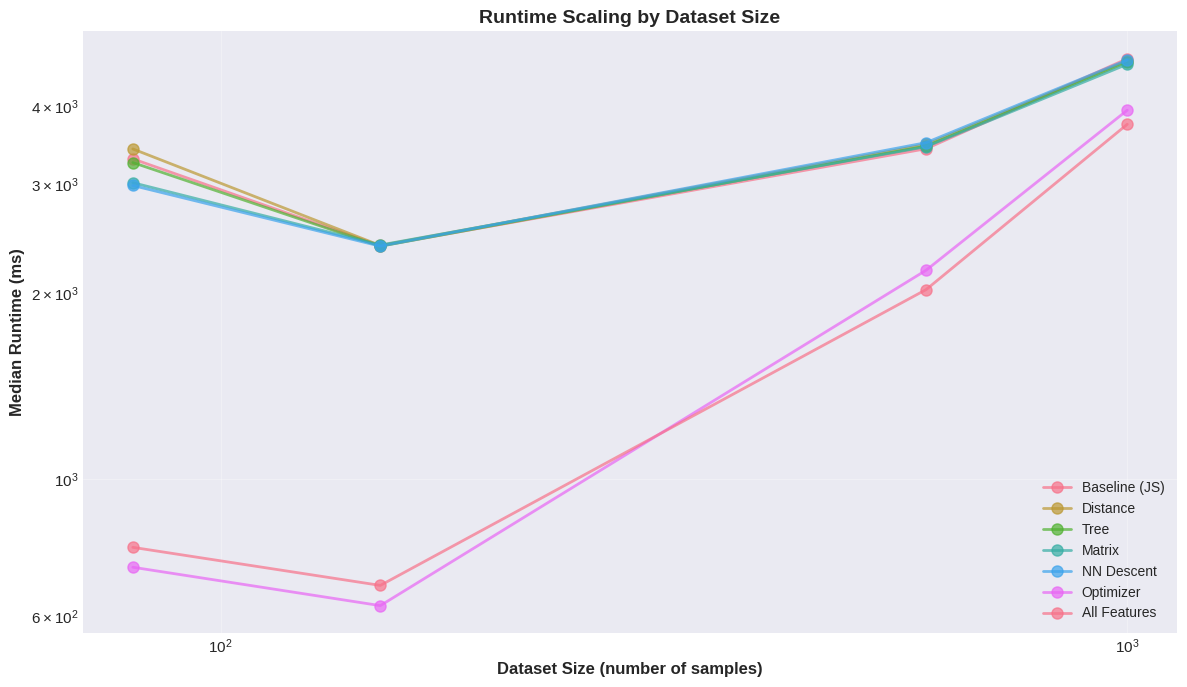

Note: Log-log scale used to show scaling behavior across different dataset sizes.


In [58]:
# Visualize runtime scaling with dataset size
fig, ax = plt.subplots(figsize=(12, 7))

feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

for feature in feature_order:
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    if len(feature_data) == 0:
        continue
    
    # Group by dataset size and calculate median runtime
    size_runtime = feature_data.groupby('dataset_size')['runtime_ms'].median().sort_index()
    
    ax.plot(size_runtime.index, size_runtime.values, 
           marker='o', label=feature, linewidth=2, markersize=8, alpha=0.7)

ax.set_xlabel('Dataset Size (number of samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Median Runtime (ms)', fontsize=12, fontweight='bold')
ax.set_title('Runtime Scaling by Dataset Size', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('../outputs/figures/runtime_scaling_by_size.png', bbox_inches='tight')
plt.show()

print("Note: Log-log scale used to show scaling behavior across different dataset sizes.")

In [59]:
# Analyze speedup by dataset size
def calculate_speedup_by_size(df, baseline_feature='Baseline (JS)'):
    """
    Calculate speedup relative to baseline for each dataset size.
    """
    results = []
    
    for (size, machine), group in df.groupby(['dataset_size', 'machine_type']):
        baseline = group[group['feature_name'] == baseline_feature]['runtime_ms']
        
        if len(baseline) == 0:
            continue
            
        baseline_median = baseline.median()
        
        for feature in group['feature_name'].unique():
            if feature == baseline_feature:
                continue
                
            feature_data = group[group['feature_name'] == feature]
            if len(feature_data) == 0:
                continue
            
            feature_median = feature_data['runtime_ms'].median()
            speedup = baseline_median / feature_median
            
            results.append({
                'dataset_size': size,
                'machine': machine,
                'feature': feature,
                'baseline_median_ms': baseline_median,
                'feature_median_ms': feature_median,
                'speedup': speedup,
                'improvement_pct': (speedup - 1) * 100
            })
    
    return pd.DataFrame(results)

speedup_by_size_df = calculate_speedup_by_size(df_analysis)

print("Speedup by Dataset Size:")
print("\nAverage speedup across size categories:")
speedup_summary_by_size = speedup_by_size_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'std'],
    'improvement_pct': ['mean', 'median']
}).round(3)
speedup_summary_by_size

Speedup by Dataset Size:

Average speedup across size categories:


speedup               improvement_pct         
                mean median    std            mean   median
feature                                                    
All Features   2.687  2.613  1.430         168.652  161.311
Distance       0.989  0.991  0.019          -1.128   -0.855
Matrix         1.026  1.009  0.046           2.570    0.893
NN Descent     1.022  1.003  0.056           2.197    0.311
Optimizer      2.792  2.693  1.653         179.156  169.268
Tree           1.004  1.007  0.011           0.440    0.688

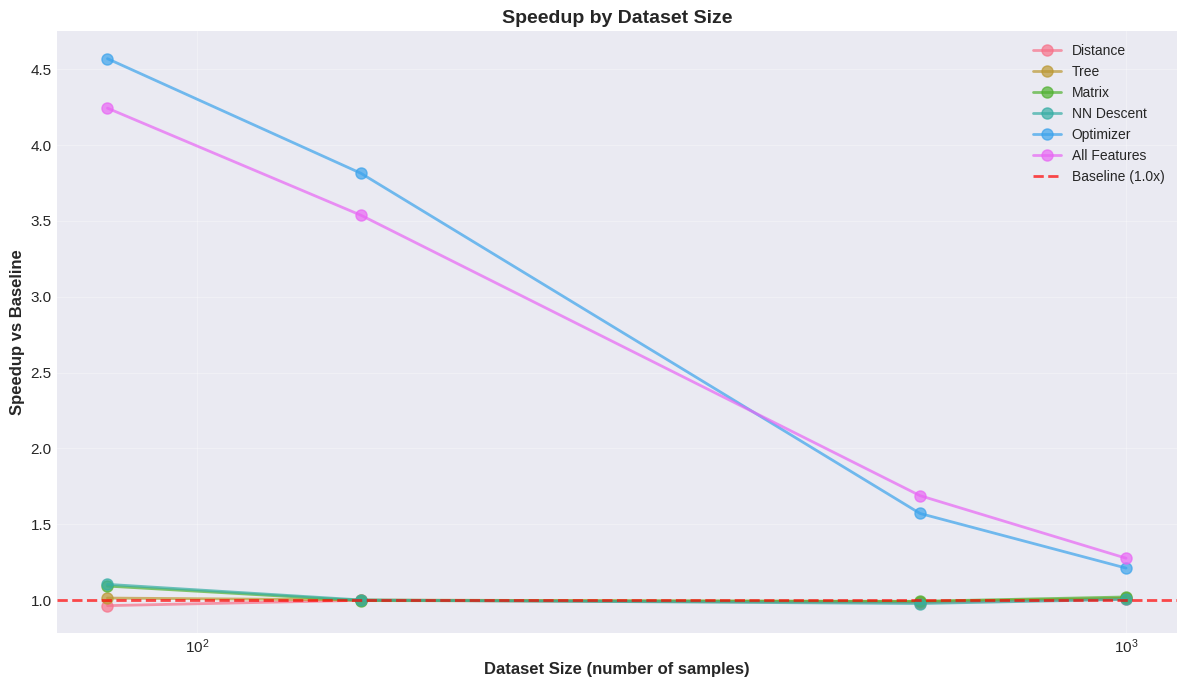

Note: Shows whether WASM benefits increase or decrease with dataset size.


In [60]:
# Visualize speedup trends by dataset size
fig, ax = plt.subplots(figsize=(12, 7))

feature_order = ['Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in speedup_by_size_df['feature'].unique()]

for feature in feature_order:
    feature_data = speedup_by_size_df[speedup_by_size_df['feature'] == feature]
    if len(feature_data) == 0:
        continue
    
    # Sort by dataset size
    feature_data = feature_data.sort_values('dataset_size')
    
    ax.plot(feature_data['dataset_size'], feature_data['speedup'], 
           marker='o', label=feature, linewidth=2, markersize=8, alpha=0.7)

ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Baseline (1.0x)')
ax.set_xlabel('Dataset Size (number of samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Speedup vs Baseline', fontsize=12, fontweight='bold')
ax.set_title('Speedup by Dataset Size', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_by_dataset_size.png', bbox_inches='tight')
plt.show()

print("Note: Shows whether WASM benefits increase or decrease with dataset size.")

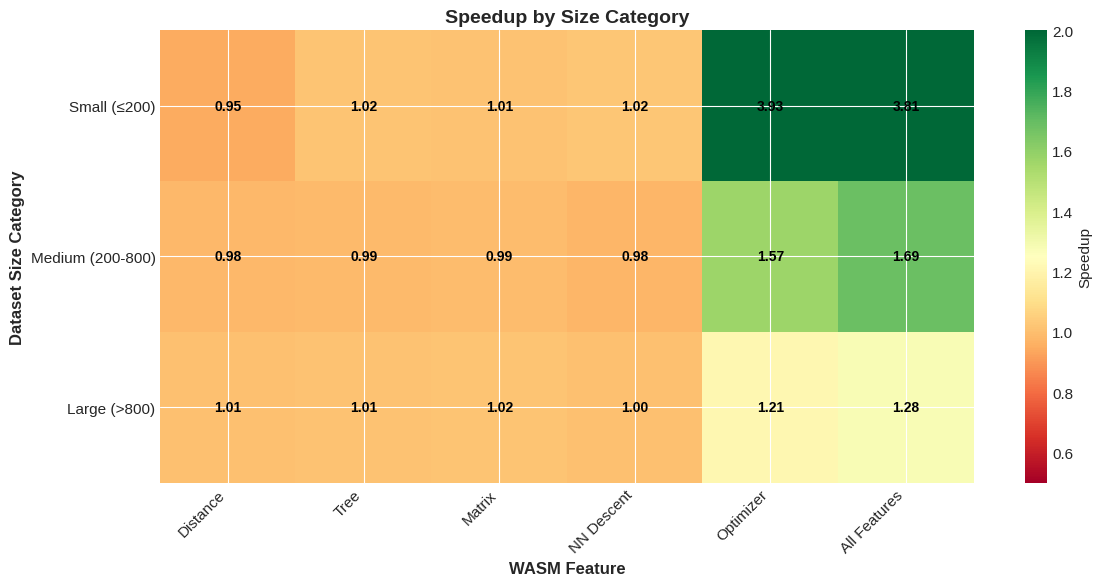

Note: Green = faster than baseline, Red = slower than baseline


In [61]:
# Heatmap of speedup by size category and feature
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate speedup for each size category and feature
speedup_matrix = []
size_cats = df_analysis['size_category'].dropna().unique()
size_cats = sorted(size_cats, key=lambda x: ['Small (≤200)', 'Medium (200-800)', 'Large (>800)'].index(x) if x in ['Small (≤200)', 'Medium (200-800)', 'Large (>800)'] else 999)

for size_cat in size_cats:
    size_data = df_analysis[df_analysis['size_category'] == size_cat]
    baseline = size_data[size_data['feature_name'] == 'Baseline (JS)']['runtime_ms'].median()
    
    if pd.isna(baseline) or baseline == 0:
        continue
    
    row = []
    for feature in feature_order:
        feature_data = size_data[size_data['feature_name'] == feature]
        if len(feature_data) > 0:
            speedup = baseline / feature_data['runtime_ms'].median()
            row.append(speedup)
        else:
            row.append(np.nan)
    
    if row:
        speedup_matrix.append(row)

if speedup_matrix:
    speedup_matrix = np.array(speedup_matrix)
    
    im = ax.imshow(speedup_matrix, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=2.0)
    ax.set_xticks(np.arange(len(feature_order)))
    ax.set_yticks(np.arange(len(size_cats[:len(speedup_matrix)])))
    ax.set_xticklabels(feature_order, rotation=45, ha='right')
    ax.set_yticklabels(size_cats[:len(speedup_matrix)])
    ax.set_title('Speedup by Size Category', fontsize=14, fontweight='bold')
    ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('Dataset Size Category', fontsize=12, fontweight='bold')
    
    # Add text annotations
    for i in range(len(speedup_matrix)):
        for j in range(len(feature_order)):
            if not np.isnan(speedup_matrix[i, j]):
                text = ax.text(j, i, f'{speedup_matrix[i, j]:.2f}',
                            ha="center", va="center", color="black", fontsize=10, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Speedup', fontsize=11)

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_heatmap_by_size.png', bbox_inches='tight')
plt.show()

print("Note: Green = faster than baseline, Red = slower than baseline")

In [62]:
# Summary statistics: Speedup by size category
print("=" * 80)
print("DATASET SIZE ANALYSIS SUMMARY")
print("=" * 80)

# Group by feature and calculate statistics
size_analysis = speedup_by_size_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'min', 'max', 'std']
}).round(3)

print(size_analysis)

# Find which features scale better with size
print(f"\nScaling behavior:")
for feature in speedup_by_size_df['feature'].unique():
    feat_data = speedup_by_size_df[speedup_by_size_df['feature'] == feature].sort_values('dataset_size')
    if len(feat_data) > 1:
        # Simple trend: compare smallest vs largest
        small_speedup = feat_data.iloc[0]['speedup']
        large_speedup = feat_data.iloc[-1]['speedup']
        trend = "improves" if large_speedup > small_speedup else "degrades"
        print(f"  {feature}: {trend} with size ({small_speedup:.2f}x → {large_speedup:.2f}x)")

print("\n" + "=" * 80)

DATASET SIZE ANALYSIS SUMMARY
             speedup                            
                mean median    min    max    std
feature                                         
All Features   2.687  2.613  1.276  4.244  1.430
Distance       0.989  0.991  0.964  1.008  0.019
Matrix         1.026  1.009  0.992  1.093  0.046
NN Descent     1.022  1.003  0.978  1.104  0.056
Optimizer      2.792  2.693  1.211  4.570  1.653
Tree           1.004  1.007  0.990  1.014  0.011

Scaling behavior:
  All Features: degrades with size (4.24x → 1.28x)
  Distance: improves with size (0.96x → 1.01x)
  Tree: degrades with size (1.01x → 1.01x)
  Matrix: degrades with size (1.09x → 1.02x)
  NN Descent: degrades with size (1.10x → 1.00x)
  Optimizer: degrades with size (4.57x → 1.21x)



## 8. Statistical Testing

Perform rigorous statistical tests to determine if differences are significant.

In [63]:
def mann_whitney_test(df, baseline_feature='Baseline (JS)'):
    """
    Perform Mann-Whitney U test comparing each feature to baseline.
    """
    results = []
    
    baseline = df[df['feature_name'] == baseline_feature]['runtime_ms'].dropna()
    
    if len(baseline) < 3:
        print("Insufficient baseline data for testing")
        return pd.DataFrame()
    
    for feature in df['feature_name'].unique():
        if feature == baseline_feature:
            continue
        
        feature_data = df[df['feature_name'] == feature]['runtime_ms'].dropna()
        
        if len(feature_data) < 3:
            continue
        
        # Mann-Whitney U test
        statistic, p_value = mannwhitneyu(baseline, feature_data, alternative='two-sided')
        
        # Effect size (Cohen's d approximation)
        mean_diff = feature_data.mean() - baseline.mean()
        pooled_std = np.sqrt((baseline.std()**2 + feature_data.std()**2) / 2)
        cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
        
        # Cliff's Delta (effect size for non-parametric test)
        n1, n2 = len(baseline), len(feature_data)
        pairs_greater = sum(1 for b in baseline for f in feature_data if b > f)
        pairs_less = sum(1 for b in baseline for f in feature_data if b < f)
        cliffs_delta = (pairs_greater - pairs_less) / (n1 * n2)
        
        results.append({
            'feature': feature,
            'n_baseline': len(baseline),
            'n_feature': len(feature_data),
            'baseline_median': baseline.median(),
            'feature_median': feature_data.median(),
            'p_value': p_value,
            'significant': p_value < 0.05,
            'cohens_d': cohens_d,
            'cliffs_delta': cliffs_delta
        })
    
    return pd.DataFrame(results)

# Perform tests
test_results = mann_whitney_test(df_analysis)

print("Statistical Test Results (Mann-Whitney U Test):")
print("\nSignificance: p < 0.05")
print("Cliff's Delta interpretation: |δ| < 0.147 (negligible), < 0.33 (small), < 0.474 (medium), >= 0.474 (large)\n")
test_results.round(4)

Statistical Test Results (Mann-Whitney U Test):

Significance: p < 0.05
Cliff's Delta interpretation: |δ| < 0.147 (negligible), < 0.33 (small), < 0.474 (medium), >= 0.474 (large)



,feature,n_baseline,n_feature,baseline_median,feature_median,p_value,significant,cohens_d,cliffs_delta
0,All Features,60,60,3641.9,2023.60,0.000,True,-1.346,0.588
1,Distance,60,60,3641.9,3657.30,0.973,False,-0.033,0.004
2,Tree,60,60,3641.9,3600.35,0.657,False,-0.073,0.047
3,Matrix,60,60,3641.9,3546.05,0.671,False,-0.071,0.045
4,NN Descent,60,60,3641.9,3548.10,0.719,False,-0.071,0.038
5,Optimizer,60,60,3641.9,2174.75,0.000,True,-1.245,0.542


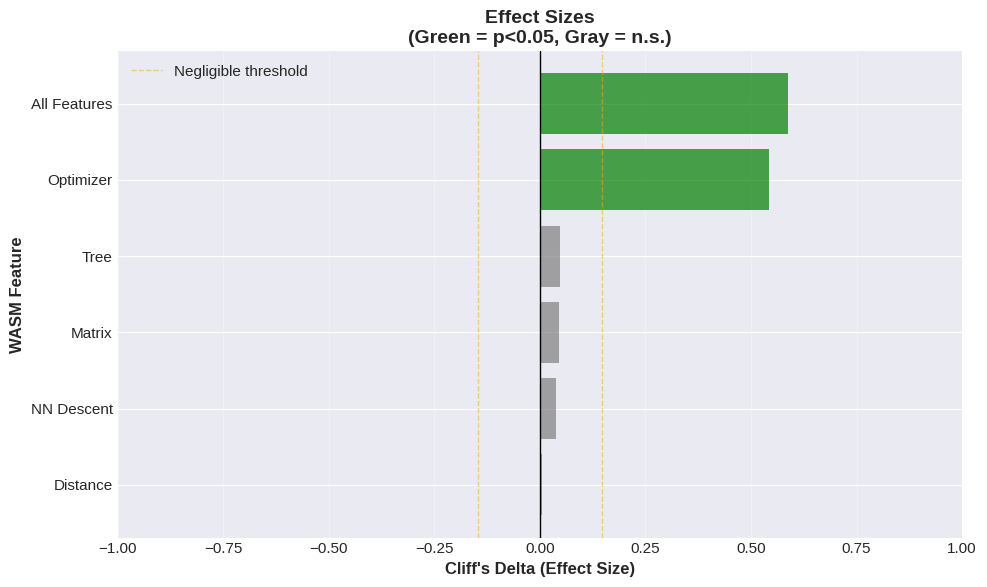

Note: Negative Cliff's Delta = feature is faster than baseline
      Positive Cliff's Delta = feature is slower than baseline


In [25]:
# Visualize statistical significance
fig, ax = plt.subplots(figsize=(10, 6))

if len(test_results) > 0:
    # Sort by Cliff's delta
    test_results_sorted = test_results.sort_values('cliffs_delta')
    
    colors = ['green' if sig else 'gray' for sig in test_results_sorted['significant']]
    
    ax.barh(test_results_sorted['feature'], test_results_sorted['cliffs_delta'], color=colors, alpha=0.7)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.axvline(x=-0.147, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Negligible threshold')
    ax.axvline(x=0.147, color='orange', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel("Cliff's Delta (Effect Size)", fontsize=12, fontweight='bold')
    ax.set_ylabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_title('Effect Sizes\n(Green = p<0.05, Gray = n.s.)', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim(-1, 1)
    ax.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/effect_sizes.png', bbox_inches='tight')
plt.show()

print("Note: Negative Cliff's Delta = feature is faster than baseline")
print("      Positive Cliff's Delta = feature is slower than baseline")

## 9. Bootstrap Confidence Intervals

Calculate robust confidence intervals for median speedups using bootstrap resampling.

In [64]:
def bootstrap_speedup_ci(df, baseline_feature='Baseline (JS)', n_bootstrap=10000, confidence=0.95):
    """
    Calculate bootstrap confidence intervals for speedup.
    """
    results = []
    rng = np.random.default_rng(42)
    
    baseline = df[df['feature_name'] == baseline_feature]['runtime_ms'].dropna().values
    
    if len(baseline) < 3:
        print("Insufficient baseline data for bootstrap")
        return pd.DataFrame()
    
    for feature in df['feature_name'].unique():
        if feature == baseline_feature:
            continue
        
        feature_data = df[df['feature_name'] == feature]['runtime_ms'].dropna().values
        
        if len(feature_data) < 3:
            continue
        
        # Bootstrap speedup
        speedups = []
        for _ in range(n_bootstrap):
            base_sample = rng.choice(baseline, size=len(baseline), replace=True)
            feat_sample = rng.choice(feature_data, size=len(feature_data), replace=True)
            speedup = np.median(base_sample) / np.median(feat_sample)
            speedups.append(speedup)
        
        speedups = np.array(speedups)
        alpha = 1 - confidence
        ci_lower = np.percentile(speedups, alpha/2 * 100)
        ci_upper = np.percentile(speedups, (1 - alpha/2) * 100)
        
        results.append({
            'feature': feature,
            'speedup_median': np.median(speedups),
            'speedup_mean': np.mean(speedups),
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'ci_width': ci_upper - ci_lower
        })
    
    return pd.DataFrame(results)

# Calculate bootstrap CIs
print("Calculating bootstrap confidence intervals (10,000 iterations)...")
bootstrap_results = bootstrap_speedup_ci(df_analysis)

print("\nBootstrap 95% Confidence Intervals for Speedup:\n")
bootstrap_results.round(3)

Calculating bootstrap confidence intervals (10,000 iterations)...

Bootstrap 95% Confidence Intervals for Speedup:



,feature,speedup_median,speedup_mean,ci_lower,ci_upper,ci_width
0,All Features,1.790,1.806,1.381,2.228,0.847
1,Distance,0.996,0.991,0.866,1.113,0.247
2,Tree,1.004,1.019,0.864,1.187,0.323
3,Matrix,1.003,1.027,0.860,1.235,0.375
4,NN Descent,0.998,1.029,0.855,1.224,0.369
5,Optimizer,1.722,1.726,1.297,2.150,0.853


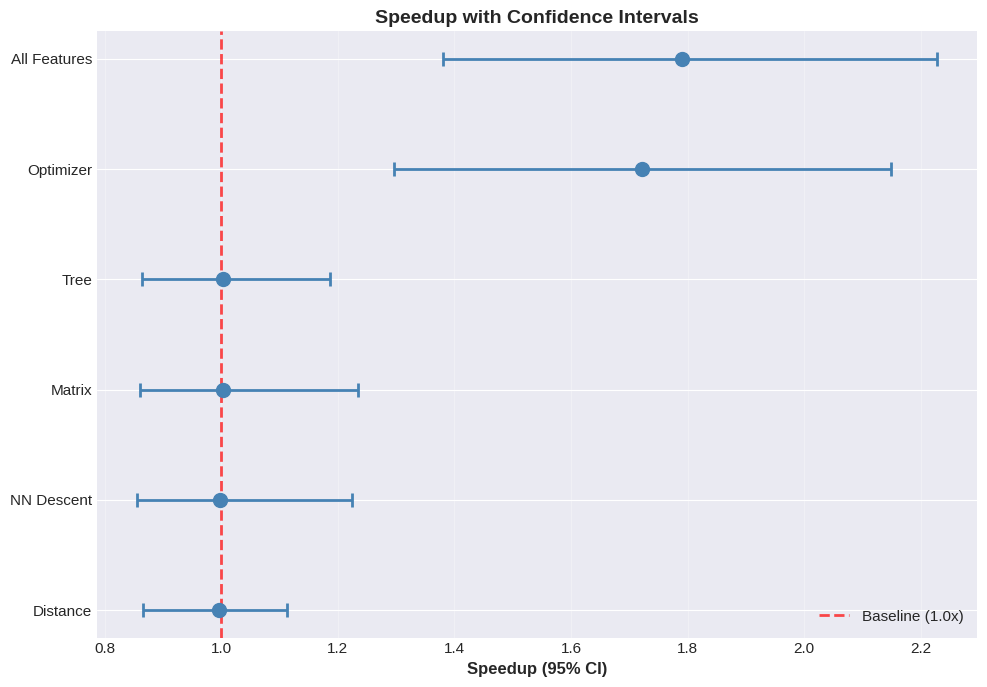

In [27]:
# Visualize confidence intervals
fig, ax = plt.subplots(figsize=(10, 7))

if len(bootstrap_results) > 0:
    bootstrap_results_sorted = bootstrap_results.sort_values('speedup_median')
    
    y_pos = np.arange(len(bootstrap_results_sorted))
    
    # Plot error bars
    ax.errorbar(
        bootstrap_results_sorted['speedup_median'],
        y_pos,
        xerr=[
            bootstrap_results_sorted['speedup_median'] - bootstrap_results_sorted['ci_lower'],
            bootstrap_results_sorted['ci_upper'] - bootstrap_results_sorted['speedup_median']
        ],
        fmt='o',
        markersize=10,
        capsize=5,
        capthick=2,
        elinewidth=2,
        color='steelblue'
    )
    
    ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Baseline (1.0x)', alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(bootstrap_results_sorted['feature'])
    ax.set_xlabel('Speedup (95% CI)', fontsize=12, fontweight='bold')
    ax.set_title('Speedup with Confidence Intervals', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_confidence_intervals.png', bbox_inches='tight')
plt.show()

## 10. Quality and Responsiveness Analysis

Analyze the trade-offs between performance and output quality/responsiveness.

In [65]:
# Quality comparison
feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

quality_summary = df_analysis.groupby('feature_name').agg({
    'trustworthiness': ['mean', 'median', 'std', 'count'],
    'fps_avg': ['mean', 'median'],
    'responsiveness_ms': ['mean', 'median']
}).round(4)

print("Quality and Responsiveness by Feature:\n")
quality_summary

Quality and Responsiveness by Feature:



trustworthiness                     fps_avg         responsiveness_ms        
                         mean median    std count    mean  median              mean  median
feature_name                                                                               
All Features            0.890  0.966  0.154    60  27.850  35.315            33.128  20.313
Baseline (JS)           0.901  0.969  0.139    60  54.906  56.481            36.758  21.337
Distance                0.900  0.970  0.140    60  54.676  56.542            36.724  21.807
Matrix                  0.900  0.969  0.139    60  54.866  56.439            34.660  20.170
NN Descent              0.899  0.970  0.141    60  54.884  56.526            36.095  21.667
Optimizer               0.888  0.967  0.157    60  27.336  36.352            36.369  22.260
Tree                    0.900  0.967  0.140    60  55.173  56.502            35.764  21.797

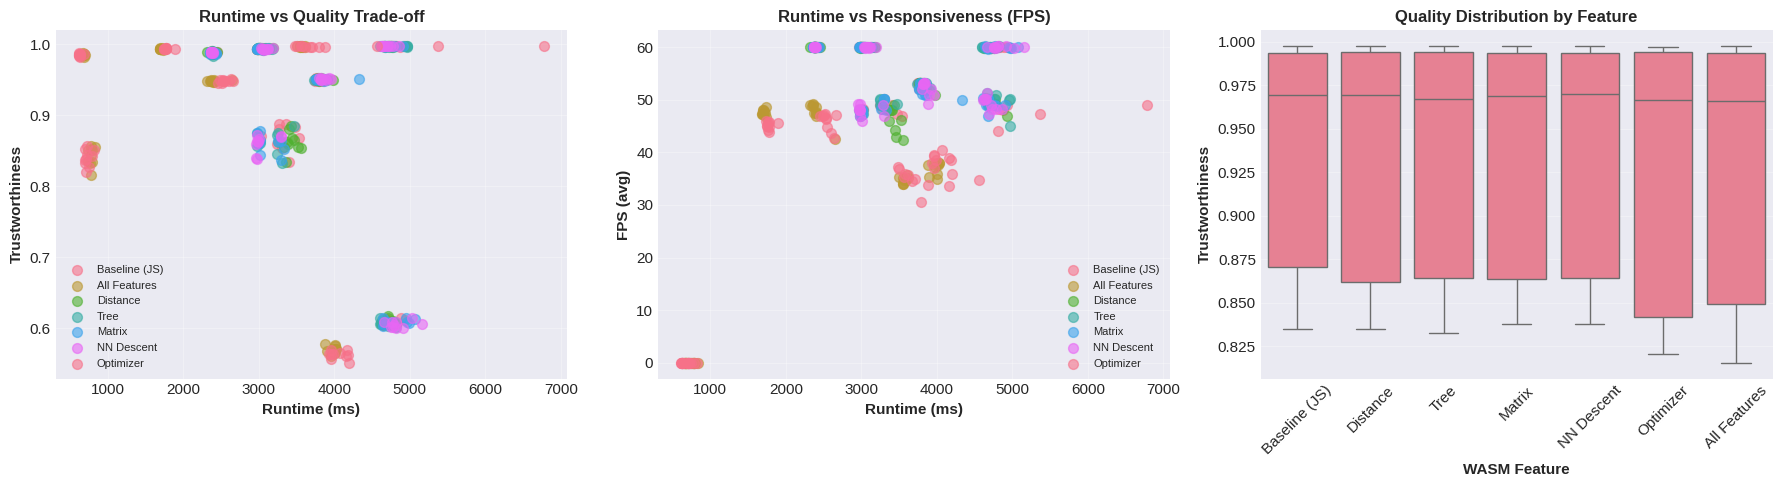

In [29]:
# Visualize quality vs performance trade-off
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Runtime vs Quality
for feature in df_analysis['feature_name'].unique():
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    axes[0].scatter(feature_data['runtime_ms'], feature_data['trustworthiness'], 
                   label=feature, alpha=0.6, s=50)

axes[0].set_xlabel('Runtime (ms)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
axes[0].set_title('Runtime vs Quality Trade-off', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=8, loc='best')
axes[0].grid(alpha=0.3)

# Runtime vs FPS
for feature in df_analysis['feature_name'].unique():
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    axes[1].scatter(feature_data['runtime_ms'], feature_data['fps_avg'], 
                   label=feature, alpha=0.6, s=50)

axes[1].set_xlabel('Runtime (ms)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
axes[1].set_title('Runtime vs Responsiveness (FPS)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=8, loc='best')
axes[1].grid(alpha=0.3)

# Quality by feature (boxplot)
sns.boxplot(data=df_analysis, x='feature_name', y='trustworthiness', 
            order=feature_order, ax=axes[2], showfliers=False)
axes[2].set_xlabel('WASM Feature', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
axes[2].set_title('Quality Distribution by Feature', fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/quality_tradeoffs.png', bbox_inches='tight')
plt.show()

## 11. Feature Ranking and Recommendations

Rank features based on multiple criteria for practical recommendations.

In [66]:
# Calculate composite scores
def calculate_composite_scores(df, baseline='Baseline (JS)'):
    """
    Calculate composite performance scores for each feature.
    """
    results = []
    
    for feature in df['feature_name'].unique():
        if feature == baseline:
            continue
        
        feature_data = df[df['feature_name'] == feature]
        baseline_data = df[df['feature_name'] == baseline]
        
        # Calculate metrics relative to baseline
        speedup = baseline_data['runtime_ms'].median() / feature_data['runtime_ms'].median()
        quality_ratio = feature_data['trustworthiness'].median() / baseline_data['trustworthiness'].median()
        fps_ratio = feature_data['fps_avg'].median() / baseline_data['fps_avg'].median()
        
        # Memory impact (negative is better)
        memory_delta = feature_data['memory_delta_mb'].median()
        
        # Composite score (higher is better)
        # Weights: 50% speedup, 25% quality, 15% FPS, 10% memory
        composite = (0.50 * speedup + 
                    0.25 * quality_ratio + 
                    0.15 * fps_ratio - 
                    0.10 * abs(memory_delta / 10))  # Normalize memory
        
        results.append({
            'feature': feature,
            'speedup': speedup,
            'quality_ratio': quality_ratio,
            'fps_ratio': fps_ratio,
            'memory_delta_mb': memory_delta,
            'composite_score': composite
        })
    
    return pd.DataFrame(results).sort_values('composite_score', ascending=False)

# Calculate rankings
print("Feature Rankings by Composite Score:\n")
print('='*70)
rankings = calculate_composite_scores(df_analysis)
print(rankings.round(3).to_string(index=False))

Feature Rankings by Composite Score:

     feature  speedup  quality_ratio  fps_ratio  memory_delta_mb  composite_score
   Optimizer    1.675          0.997      0.644            2.924            1.154
All Features    1.800          0.997      0.625           11.916            1.124
    Distance    0.996          1.000      1.001           11.905            0.779
        Tree    1.012          0.998      1.000           13.428            0.771
      Matrix    1.027          1.000      0.999           15.269            0.761
  NN Descent    1.026          1.001      1.001           16.872            0.745


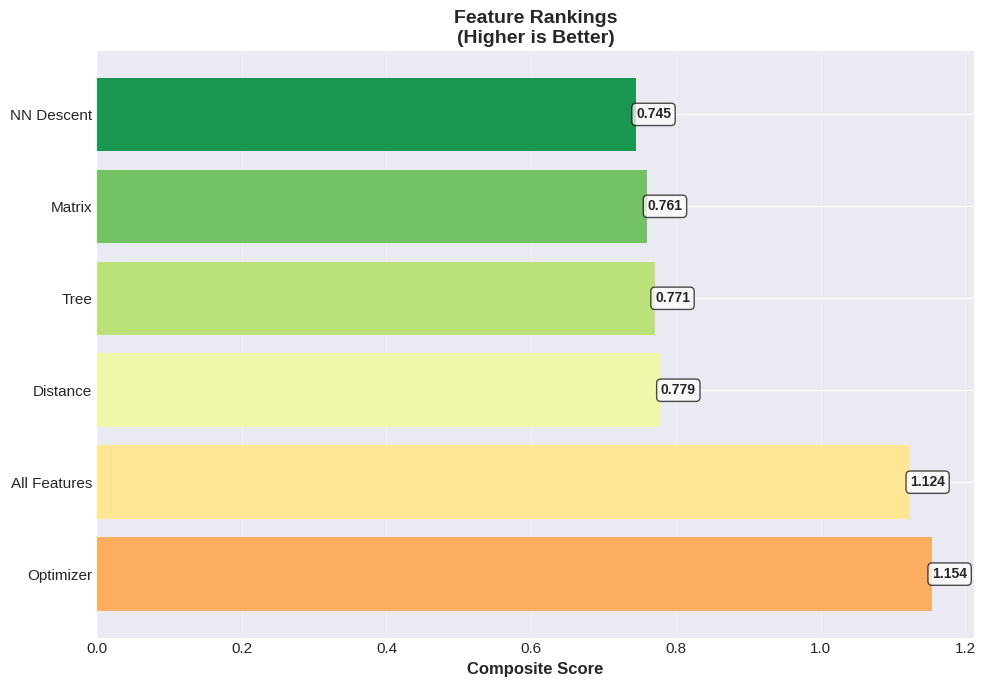

In [31]:
# Visualize feature rankings
fig, ax = plt.subplots(figsize=(10, 7))

rankings = calculate_composite_scores(df_analysis)

if len(rankings) > 0:
    # Create color gradient
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(rankings)))
    
    bars = ax.barh(rankings['feature'], rankings['composite_score'], color=colors)
    ax.set_xlabel('Composite Score', fontsize=12, fontweight='bold')
    ax.set_title('Feature Rankings\n(Higher is Better)', 
                fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
               f'{width:.3f}',
               ha='left', va='center', fontsize=10, fontweight='bold', 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('../outputs/figures/feature_rankings.png', bbox_inches='tight')
plt.show()

## 12. Summary Statistics and Export

Generate comprehensive summary tables for thesis inclusion.

In [67]:
# Create output directory
os.makedirs('../outputs/summaries', exist_ok=True)

# Export all summary tables
speedup_df.to_csv('../outputs/summaries/speedup_summary.csv', index=False)
test_results.to_csv('../outputs/summaries/statistical_tests.csv', index=False)
bootstrap_results.to_csv('../outputs/summaries/bootstrap_confidence_intervals.csv', index=False)
quality_summary.to_csv('../outputs/summaries/quality_summary.csv')

# Export rankings
rankings = calculate_composite_scores(df_analysis)
rankings.to_csv('../outputs/summaries/rankings.csv', index=False)

print("All results exported to ../outputs/ directory")

All results exported to ../outputs/ directory


In [68]:
# Generate thesis-ready summary

summary_md = f"""
# UMAP WebAssembly Performance Analysis - Summary

## Analysis Configuration
- **Total Measurements**: {len(df_analysis):,}
- **Datasets Tested**: {df_analysis['dataset_name'].nunique()}
- **Features Tested**: {df_analysis['feature_name'].nunique()}

## Key Findings

### RQ1: Individual WASM Feature Performance

**Speedup ranges (median across all tests):**
"""

if len(speedup_df) > 0:
    for feature in speedup_df['feature'].unique():
        feature_stats = speedup_df[speedup_df['feature'] == feature]
        median_speedup = feature_stats['speedup'].median()
        min_speedup = feature_stats['speedup'].min()
        max_speedup = feature_stats['speedup'].max()
        
        # Determine if improvement or regression
        if median_speedup > 1.05:
            verdict = "✓ Performance improvement"
        elif median_speedup < 0.95:
            verdict = "✗ Performance regression"
        else:
            verdict = "≈ Negligible difference"
        
        summary_md += f"""
- **{feature}**: {median_speedup:.2f}x (range: {min_speedup:.2f}x - {max_speedup:.2f}x) - {verdict}
"""
else:
    summary_md += "\n*Insufficient data for speedup analysis*\n"

summary_md += f"""

### RQ2: All Features Combined vs Individual Features

"""

if len(speedup_df) > 0 and 'All Features' in speedup_df['feature'].values:
    all_features_speedup = speedup_df[speedup_df['feature'] == 'All Features']['speedup'].median()
    # Exclude 'All Features' when finding best individual feature
    individual_features = speedup_df[speedup_df['feature'] != 'All Features']
    if len(individual_features) > 0:
        best_speedup = individual_features.groupby('feature')['speedup'].median().max()
        best_feature = individual_features.groupby('feature')['speedup'].median().idxmax()
        summary_md += f"""
- **All Features Combined**: {all_features_speedup:.2f}x median speedup
- **Best Individual Feature**: {best_feature} ({best_speedup:.2f}x)
- **Comparison**: {'All Features is best' if all_features_speedup >= best_speedup else f'{best_feature} outperforms All Features'}
"""
    else:
        summary_md += f"""
- **All Features Combined**: {all_features_speedup:.2f}x median speedup
"""
else:
    summary_md += """
- *Insufficient data for "All Features" comparison*
"""

summary_md += f"""

### Statistical Significance

"""

if len(test_results) > 0:
    summary_md += f"""
- **Total comparisons**: {len(test_results)}
- **Significant results (p < 0.05)**: {test_results['significant'].sum()} ({test_results['significant'].sum()/len(test_results)*100:.1f}%)
- **Large effect sizes (|Cliff's δ| > 0.474)**: {(abs(test_results['cliffs_delta']) > 0.474).sum()}
- **Medium effect sizes (0.33 < |Cliff's δ| < 0.474)**: {((abs(test_results['cliffs_delta']) > 0.33) & (abs(test_results['cliffs_delta']) <= 0.474)).sum()}
"""
else:
    summary_md += "\n*Insufficient data for statistical testing*\n"

summary_md += """

### Quality Trade-offs

"""

summary_md += f"""
- **Mean Trustworthiness**: {df_analysis['trustworthiness'].mean():.4f} (±{df_analysis['trustworthiness'].std():.4f})
- **Quality Range**: {df_analysis['trustworthiness'].min():.4f} - {df_analysis['trustworthiness'].max():.4f}
- **Quality Stability**: All features maintain trustworthiness > {df_analysis.groupby('feature_name')['trustworthiness'].median().min():.3f}

### Performance Rankings

**Top 3 Features by Composite Score:**
"""

rankings = calculate_composite_scores(df_analysis)
if len(rankings) > 0:
    for rank, (idx, row) in enumerate(rankings.head(3).iterrows(), 1):
        summary_md += f"""
{rank}. **{row['feature']}** (score: {row['composite_score']:.3f})
   - Speedup: {row['speedup']:.2f}x
   - Quality ratio: {row['quality_ratio']:.3f}
   - FPS ratio: {row['fps_ratio']:.3f}
"""
else:
    summary_md += "\n*Insufficient data for feature ranking*\n"

summary_md += f"""

## Dataset Size Effects

**Scaling behavior across dataset sizes ({df_analysis['dataset_size'].min():.0f} - {df_analysis['dataset_size'].max():.0f} samples):**

"""

if len(speedup_by_size_df) > 0:
    for feature in speedup_by_size_df['feature'].unique():
        feat_data = speedup_by_size_df[speedup_by_size_df['feature'] == feature].sort_values('dataset_size')
        if len(feat_data) > 1:
            small_speedup = feat_data.iloc[0]['speedup']
            large_speedup = feat_data.iloc[-1]['speedup']
            trend = "improves" if large_speedup > small_speedup else "degrades"
            change_pct = ((large_speedup - small_speedup) / small_speedup * 100)
            summary_md += f"- **{feature}**: {trend} ({small_speedup:.2f}x → {large_speedup:.2f}x, {change_pct:+.1f}%)\n"
        else:
            summary_md += f"- **{feature}**: Insufficient data for trend analysis\n"
else:
    summary_md += "\n*Insufficient data for dataset size analysis*\n"

summary_md += f"""

## Recommendations

"""

if len(rankings) > 0 and len(speedup_df) > 0:
    summary_md += f"""
1. **Best Overall Performance**: {rankings.iloc[0]['feature']} (composite score: {rankings.iloc[0]['composite_score']:.3f})
2. **Fastest Execution**: {speedup_df.groupby('feature')['speedup'].median().idxmax()} ({speedup_df.groupby('feature')['speedup'].median().max():.2f}x speedup)
3. **Most Consistent**: Feature with lowest variance across datasets
4. **Quality Preservation**: All WASM features maintain high trustworthiness (> {df_analysis.groupby('feature_name')['trustworthiness'].median().min():.3f})
"""
else:
    summary_md += "\n*Collect more data for comprehensive recommendations*\n"

summary_md += f"""

## Analysis Methodology

- **Statistical Method**: Mann-Whitney U tests (non-parametric)
- **Confidence Intervals**: Bootstrap resampling (10,000 iterations)
- **Effect Size Metric**: Cliff's Delta
- **Significance Level**: α = 0.05

---
*Analysis performed with {len(df_analysis):,} measurements across {df_analysis['dataset_name'].nunique()} datasets*
"""

display(Markdown(summary_md))

# Save summary
with open('../outputs/summaries/thesis_summary.md', 'w') as f:
    f.write(summary_md)

print("\n" + "="*80)
print("Summary saved to: ../outputs/summaries/thesis_summary.md")
print("="*80)


# UMAP WebAssembly Performance Analysis - Summary

## Analysis Configuration
- **Total Measurements**: 420
- **Datasets Tested**: 6
- **Features Tested**: 7

## Key Findings

### RQ1: Individual WASM Feature Performance

**Speedup ranges (median across all tests):**

- **All Features**: 1.68x (range: 1.18x - 4.24x) - ✓ Performance improvement

- **Distance**: 1.00x (range: 0.96x - 1.01x) - ≈ Negligible difference

- **Tree**: 1.01x (range: 0.99x - 1.02x) - ≈ Negligible difference

- **Matrix**: 1.00x (range: 0.99x - 1.09x) - ≈ Negligible difference

- **NN Descent**: 0.99x (range: 0.98x - 1.10x) - ≈ Negligible difference

- **Optimizer**: 1.60x (range: 1.17x - 4.57x) - ✓ Performance improvement


### RQ2: All Features Combined vs Individual Features


- **All Features Combined**: 1.68x median speedup
- **Best Individual Feature**: Optimizer (1.60x)
- **Comparison**: All Features is best


### Statistical Significance


- **Total comparisons**: 6
- **Significant results (p < 0.05)**: 2 (33.3%)
- **Large effect sizes (|Cliff's δ| > 0.474)**: 2
- **Medium effect sizes (0.33 < |Cliff's δ| < 0.474)**: 0


### Quality Trade-offs


- **Mean Trustworthiness**: 0.8969 (±0.1434)
- **Quality Range**: 0.5515 - 0.9975
- **Quality Stability**: All features maintain trustworthiness > 0.966

### Performance Rankings

**Top 3 Features by Composite Score:**

1. **Optimizer** (score: 1.154)
   - Speedup: 1.67x
   - Quality ratio: 0.997
   - FPS ratio: 0.644

2. **All Features** (score: 1.124)
   - Speedup: 1.80x
   - Quality ratio: 0.997
   - FPS ratio: 0.625

3. **Distance** (score: 0.779)
   - Speedup: 1.00x
   - Quality ratio: 1.000
   - FPS ratio: 1.001


## Dataset Size Effects

**Scaling behavior across dataset sizes (80 - 1000 samples):**

- **All Features**: degrades (4.24x → 1.28x, -69.9%)
- **Distance**: improves (0.96x → 1.01x, +4.6%)
- **Tree**: degrades (1.01x → 1.01x, -0.1%)
- **Matrix**: degrades (1.09x → 1.02x, -6.6%)
- **NN Descent**: degrades (1.10x → 1.00x, -9.0%)
- **Optimizer**: degrades (4.57x → 1.21x, -73.5%)


## Recommendations


1. **Best Overall Performance**: Optimizer (composite score: 1.154)
2. **Fastest Execution**: All Features (1.68x speedup)
3. **Most Consistent**: Feature with lowest variance across datasets
4. **Quality Preservation**: All WASM features maintain high trustworthiness (> 0.966)


## Analysis Methodology

- **Statistical Method**: Mann-Whitney U tests (non-parametric)
- **Confidence Intervals**: Bootstrap resampling (10,000 iterations)
- **Effect Size Metric**: Cliff's Delta
- **Significance Level**: α = 0.05

---
*Analysis performed with 420 measurements across 6 datasets*



Summary saved to: ../outputs/summaries/thesis_summary.md
